Importing Libraries


In [ ]:
import os
import math
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans

Zip File extraction

In [ ]:
zip_file_path = "/content/data.zip"
extract_folder = "/content/data"

os.makedirs(extract_folder, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as z:
    z.extractall(extract_folder)

file_names = [
    "sample_dates_formated_market_cap.csv", "sample_dates_formated_PE.csv",
    "sample_dates_formated_PB.csv", "sample_dates_formated_BV.csv",
    "sample_dates_formated_open.csv", "sample_dates_formated_high.csv",
    "sample_dates_formated_low.csv", "sample_dates_formated_close.csv",
    "sample_dates_formated_eps.csv", "sample_dates_formated_pat.csv",
    "sample_dates_formated_ROCE.csv", "sample_dates_formated_net_profit_margin.csv",
    "sample_dates_formated_quick_ratio.csv", "sample_dates_formated_current_ratio.csv",
    "sample_dates_formated_debt_to_equity.csv", "sample_dates_formated_saless.csv"
]

Extraction of Data Frames

In [ ]:
dfs = {}

for file_name in file_names:
    file_path = os.path.join(extract_folder, file_name)
    if os.path.exists(file_path):
        dfs[file_name] = pd.read_csv(file_path)
    else:
        print(f"Warning: {file_name} not found in extracted files.")

market_cap_df = dfs["sample_dates_formated_market_cap.csv"]
pe_df = dfs["sample_dates_formated_PE.csv"]
pb_df = dfs["sample_dates_formated_PB.csv"]
bv_df = dfs["sample_dates_formated_BV.csv"]
open_df = dfs["sample_dates_formated_open.csv"]
high_df = dfs["sample_dates_formated_high.csv"]
low_df = dfs["sample_dates_formated_low.csv"]
close_df = dfs["sample_dates_formated_close.csv"]
eps_df = dfs["sample_dates_formated_eps.csv"]
pat_df = dfs["sample_dates_formated_pat.csv"]
roce_df = dfs["sample_dates_formated_ROCE.csv"]
npm_df = dfs["sample_dates_formated_net_profit_margin.csv"]
quick_ratio_df = dfs["sample_dates_formated_quick_ratio.csv"]
current_ratio_df = dfs["sample_dates_formated_current_ratio.csv"]
debt_to_equity_df = dfs["sample_dates_formated_debt_to_equity.csv"]
sales_df = dfs["sample_dates_formated_saless.csv"]

In [ ]:
'''def filter_data_by_date(df, date_col="DATE", max_year=2021):
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce", dayfirst=True)
    df = df[df[date_col].notna()]
    df = df[df[date_col].dt.year <= max_year]
    return df'''

In [ ]:
def filter_data_by_date(df, date_col="DATE", max_year=2022):
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce", dayfirst=True)
    df = df[df[date_col].notna()]
    df = df[df[date_col].dt.year <= max_year]
    return df

In [ ]:
'''def filter_data_by_date(df, date_col="DATE", max_year=2023):
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce", dayfirst=True)
    df = df[df[date_col].notna()]
    df = df[df[date_col].dt.year <= max_year]
    return df'''

Filtering by DATE

In [ ]:

eps_df = filter_data_by_date(eps_df, "DATE")
roce_df = filter_data_by_date(roce_df, "Date")
npm_df = filter_data_by_date(npm_df, "Date")
pat_df = filter_data_by_date(pat_df, "Date")
pe_df = filter_data_by_date(pe_df,"DATE")
pb_df =filter_data_by_date(pb_df,"DATE")
bv_df = filter_data_by_date(bv_df,"DATE")
open_df = filter_data_by_date(open_df,"DATE")
high_df = filter_data_by_date(high_df,"DATE")
low_df =  filter_data_by_date(low_df,"DATE")
close_df =filter_data_by_date(close_df,"DATE")
sales_df = filter_data_by_date(sales_df,"Date")
market_cap_df = filter_data_by_date(market_cap_df,"DATE")
quick_ratio_df = filter_data_by_date(quick_ratio_df,"Date")
current_ratio_df =filter_data_by_date(current_ratio_df,"Date")
debt_to_equity_df = filter_data_by_date(debt_to_equity_df,"Date")

In [ ]:
dfs = {
    "Market Cap": market_cap_df,
    "PE": pe_df,
    "PB": pb_df,
    "BV": bv_df,
    "Open": open_df,
    "High": high_df,
    "Low": low_df,
    "Close": close_df,
    "Sales": sales_df,
    "EPS": eps_df,
    "PAT": pat_df,
    "ROCE": roce_df,
    "NPM": npm_df,
    "Quick Ratio": quick_ratio_df,
    "Current Ratio": current_ratio_df,
    "Debt to Equity": debt_to_equity_df,
}

for name, df in dfs.items():
    print(f"Last 3 rows of {name} DataFrame:")
    print(df.tail(3))
    print("-" * 50)


Last 3 rows of Market Cap DataFrame:
          DATE 360 One Wam Ltd.  3M India Ltd.  A B B India Ltd.  A C C Ltd.  \
676 2022-12-17        163951.21      260093.57         601501.92   491392.32   
677 2022-12-24        155621.89      252610.75         568073.38   445825.74   
678 2022-12-31        158068.77      247190.56         568550.17   458501.38   

     A I A Engineering Ltd. A P L Apollo Tubes Ltd.  \
676               252061.76               309251.59   
677               242360.91               287952.58   
678               241927.03               302845.25   

    A U Small Finance Bank Ltd. Aadhar Housing Finance Ltd.  \
676                      444545                               
677                   429383.62                               
678                   436198.85                               

     Aarti Industries Ltd.  ... Welspun Living Ltd. Westlife Foodworld Ltd.  \
676              228051.29  ...            78155.43               120285.04   
677       

Computation of Time Weighted Scores

In [ ]:
def compute_time_weighted_scores(df, lambda_val=0.5):
    scores = {}
    for stock in df.columns[1:]:
        stock_data = pd.to_numeric(df[stock], errors='coerce').dropna()
        if len(stock_data) > 0:
            T = len(stock_data)
            weights = np.exp(-lambda_val * (T - np.arange(1, T + 1)))
            weighted_avg = np.average(stock_data, weights=weights)
            scores[stock] = weighted_avg
        else:
            scores[stock] = 0
    return pd.DataFrame(scores.items(), columns=["Stock", "Time-Weighted Score"])

Computation of Risk Weighted Scores

In [ ]:
def compute_risk_weighted_scores(df):
    scores = {}
    total_periods = len(df)

    for stock in df.columns[1:]:
        stock_data = pd.to_numeric(df[stock], errors='coerce').dropna()
        available_periods = len(stock_data)

        if available_periods > 0:
            std_dev = np.std(stock_data)
            adjusted_std_dev = np.log(1 + std_dev)
            base_score = 1 / (1 + adjusted_std_dev)

            confidence_factor = available_periods / total_periods
            final_score = base_score * confidence_factor

            scores[stock] = final_score
        else:
            scores[stock] = 0

    return pd.DataFrame(scores.items(), columns=["Stock", "Risk-Weighted Score"])

Creation of Scores Folder

In [ ]:
folder_path = "/content/scores"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    print(f"Folder '{folder_path}' created successfully.")
else:
    print(f"Folder '{folder_path}' already exists.")

Folder '/content/scores' already exists.


Computation of Liquidity Scores


🔹 Best Hyperparameters Found by Grid Search:
{'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.8}


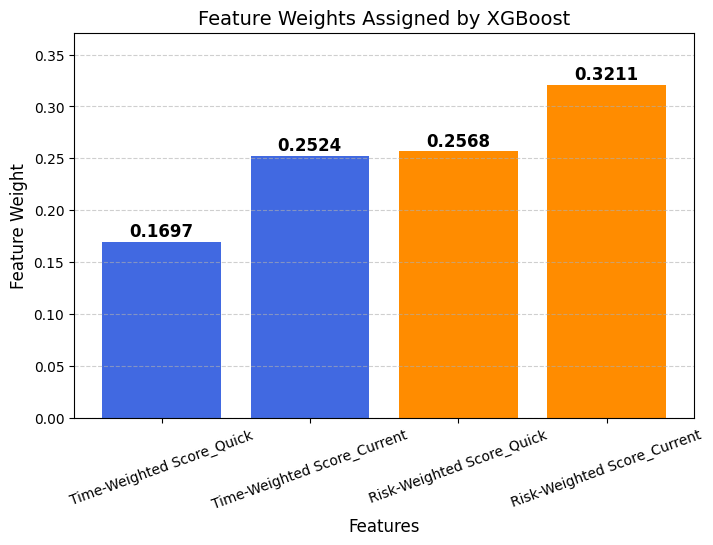

'/content/scores/final_liquidity_scores.csv'

In [ ]:
quick_scores_df = compute_time_weighted_scores(quick_ratio_df)
current_scores_df = compute_time_weighted_scores(current_ratio_df)

quick_risk_scores_df = compute_risk_weighted_scores(quick_ratio_df)
current_risk_scores_df = compute_risk_weighted_scores(current_ratio_df)

combined_scores_df = quick_scores_df.merge(current_scores_df, on="Stock", how="outer", suffixes=("_Quick", "_Current"))
combined_risk_df = quick_risk_scores_df.merge(current_risk_scores_df, on="Stock", how="outer", suffixes=("_Quick", "_Current"))
full_scores_df = combined_scores_df.merge(combined_risk_df, on="Stock", how="outer")

scaler = MinMaxScaler()
full_scores_df[["Time-Weighted Score_Quick", "Time-Weighted Score_Current", "Risk-Weighted Score_Quick", "Risk-Weighted Score_Current"]] = scaler.fit_transform(
    full_scores_df[["Time-Weighted Score_Quick", "Time-Weighted Score_Current", "Risk-Weighted Score_Quick", "Risk-Weighted Score_Current"]])

np.random.seed(42)
y_train = np.random.rand(len(full_scores_df))

X_train = full_scores_df[["Time-Weighted Score_Quick", "Time-Weighted Score_Current", "Risk-Weighted Score_Quick", "Risk-Weighted Score_Current"]]
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0]
}
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
grid_search = GridSearchCV(xgb_model, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_xgb = grid_search.best_estimator_
best_xgb.fit(X_train, y_train)

feature_weights = best_xgb.feature_importances_
feature_names = ["Time-Weighted Score_Quick", "Time-Weighted Score_Current", "Risk-Weighted Score_Quick", "Risk-Weighted Score_Current"]

full_scores_df["Final Score"] = sum(full_scores_df[feature] * weight for feature, weight in zip(feature_names, feature_weights))
full_scores_df["Rank"] = full_scores_df["Final Score"].rank(method="min", ascending=False).astype(int)
full_scores_df["Normalized Score"] = 10 * ((len(full_scores_df) - full_scores_df["Rank"]) / (len(full_scores_df) - 1))

final_scores_path = "/content/scores/final_liquidity_scores.csv"
full_scores_df.to_csv(final_scores_path, index=False)

print("\n🔹 Best Hyperparameters Found by Grid Search:")
print(grid_search.best_params_)

colors = ["royalblue","royalblue", "darkorange","darkorange"]
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(feature_names, feature_weights, color=colors)

for bar, weight in zip(bars, feature_weights):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, f"{weight:.4f}", ha="center", fontsize=12, fontweight="bold", color="black")

ax.set_ylabel("Feature Weight", fontsize=12)
ax.set_xlabel("Features", fontsize=12)
ax.set_title("Feature Weights Assigned by XGBoost", fontsize=14)
ax.set_ylim(0, max(feature_weights) + 0.05)
ax.grid(axis="y", linestyle="--", alpha=0.6)
plt.xticks(rotation=20)
plt.show()

final_scores_path

Computation of Profitability Scores


🔹 Best Hyperparameters Found by Grid Search:
{'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8}


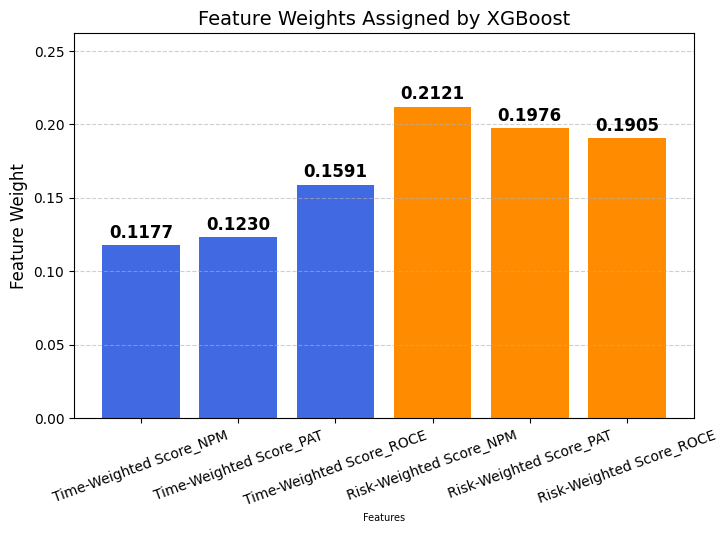

'/content/scores/final_profitability_scores.csv'

In [ ]:
npm_time_df = compute_time_weighted_scores(npm_df)
pat_time_df = compute_time_weighted_scores(pat_df)
roce_time_df = compute_time_weighted_scores(roce_df)

npm_risk_df = compute_risk_weighted_scores(npm_df)
pat_risk_df = compute_risk_weighted_scores(pat_df)
roce_risk_df = compute_risk_weighted_scores(roce_df)

combined_time_df = npm_time_df.merge(pat_time_df, on="Stock", how="outer", suffixes=("_NPM", "_PAT"))
combined_time_df = combined_time_df.merge(roce_time_df, on="Stock", how="outer")
combined_time_df.rename(columns={"Time-Weighted Score": "Time-Weighted Score_ROCE"}, inplace=True)

combined_risk_df = npm_risk_df.merge(pat_risk_df, on="Stock", how="outer", suffixes=("_NPM", "_PAT"))
combined_risk_df = combined_risk_df.merge(roce_risk_df, on="Stock", how="outer")
combined_risk_df.rename(columns={"Risk-Weighted Score": "Risk-Weighted Score_ROCE"}, inplace=True)

full_scores_df = combined_time_df.merge(combined_risk_df, on="Stock", how="outer")

scaler = MinMaxScaler()
columns_to_scale = [
    "Time-Weighted Score_NPM", "Time-Weighted Score_PAT", "Time-Weighted Score_ROCE",
    "Risk-Weighted Score_NPM", "Risk-Weighted Score_PAT", "Risk-Weighted Score_ROCE"
]
full_scores_df[columns_to_scale] = scaler.fit_transform(full_scores_df[columns_to_scale])

np.random.seed(42)
y_train = np.random.rand(len(full_scores_df))

X_train = full_scores_df[columns_to_scale]
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0]
}

xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
grid_search = GridSearchCV(xgb_model, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_xgb = grid_search.best_estimator_
best_xgb.fit(X_train, y_train)

feature_weights = best_xgb.feature_importances_
feature_names = columns_to_scale

full_scores_df["Final Score"] = sum(full_scores_df[feature] * weight for feature, weight in zip(feature_names, feature_weights))

full_scores_df["Rank"] = full_scores_df["Final Score"].rank(method="min", ascending=False)
full_scores_df["Rank"] = full_scores_df["Rank"].fillna(len(full_scores_df)).astype(int)

full_scores_df["Normalized Score"] = 10 * ((len(full_scores_df) - full_scores_df["Rank"]) / (len(full_scores_df) - 1))

final_scores_path = "/content/scores/final_profitability_scores.csv"
full_scores_df.to_csv(final_scores_path, index=False)

print("\n🔹 Best Hyperparameters Found by Grid Search:")
print(grid_search.best_params_)

colors = ["royalblue", "royalblue", "royalblue", "darkorange","darkorange","darkorange"]
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(feature_names, feature_weights, color=colors)

for bar, weight in zip(bars, feature_weights):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, f"{weight:.4f}", ha="center", fontsize=12, fontweight="bold", color="black")

ax.set_ylabel("Feature Weight", fontsize=12)
ax.set_xlabel("Features", fontsize=7)
ax.set_title("Feature Weights Assigned by XGBoost", fontsize=14)
ax.set_ylim(0, max(feature_weights) + 0.05)
ax.grid(axis="y", linestyle="--", alpha=0.6)
plt.xticks(rotation=20)
plt.show()

final_scores_path

Computation of Valuability Scores


🔹 Best Hyperparameters Found by Grid Search:
{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}


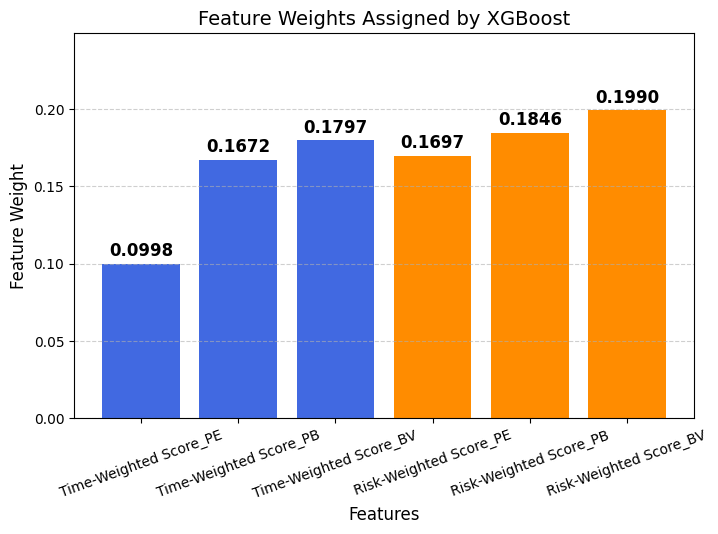

'/content/scores/final_valuation_scores.csv'

In [ ]:
pe_time_df = compute_time_weighted_scores(pe_df)
pb_time_df = compute_time_weighted_scores(pb_df)
bv_time_df = compute_time_weighted_scores(bv_df)

pe_risk_df = compute_risk_weighted_scores(pe_df)
pb_risk_df = compute_risk_weighted_scores(pb_df)
bv_risk_df = compute_risk_weighted_scores(bv_df)

combined_time_df = pe_time_df.merge(pb_time_df, on="Stock", how="outer", suffixes=("_PE", "_PB"))
combined_time_df = combined_time_df.merge(bv_time_df, on="Stock", how="outer")
combined_time_df.rename(columns={"Time-Weighted Score": "Time-Weighted Score_BV"}, inplace=True)

combined_risk_df = pe_risk_df.merge(pb_risk_df, on="Stock", how="outer", suffixes=("_PE", "_PB"))
combined_risk_df = combined_risk_df.merge(bv_risk_df, on="Stock", how="outer")
combined_risk_df.rename(columns={"Risk-Weighted Score": "Risk-Weighted Score_BV"}, inplace=True)

full_scores_df = combined_time_df.merge(combined_risk_df, on="Stock", how="outer")

scaler = MinMaxScaler()
columns_to_scale = [
    "Time-Weighted Score_PE", "Time-Weighted Score_PB", "Time-Weighted Score_BV",
    "Risk-Weighted Score_PE", "Risk-Weighted Score_PB", "Risk-Weighted Score_BV"
]
full_scores_df[columns_to_scale] = scaler.fit_transform(full_scores_df[columns_to_scale])

np.random.seed(42)
y_train = np.random.rand(len(full_scores_df))

X_train = full_scores_df[columns_to_scale]
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0]
}

xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
grid_search = GridSearchCV(xgb_model, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_xgb = grid_search.best_estimator_
best_xgb.fit(X_train, y_train)

feature_weights = best_xgb.feature_importances_
feature_names = columns_to_scale

full_scores_df["Final Score"] = sum(full_scores_df[feature] * weight for feature, weight in zip(feature_names, feature_weights))

full_scores_df["Rank"] = full_scores_df["Final Score"].rank(method="min", ascending=False)
full_scores_df["Rank"] = full_scores_df["Rank"].fillna(len(full_scores_df)).astype(int)

full_scores_df["Normalized Score"] = 10 * ((len(full_scores_df) - full_scores_df["Rank"]) / (len(full_scores_df) - 1))

final_scores_path = "/content/scores/final_valuation_scores.csv"
full_scores_df.to_csv(final_scores_path, index=False)

print("\n🔹 Best Hyperparameters Found by Grid Search:")
print(grid_search.best_params_)

colors = ["royalblue","royalblue","royalblue", "darkorange","darkorange","darkorange"]
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(feature_names, feature_weights, color=colors)

for bar, weight in zip(bars, feature_weights):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, f"{weight:.4f}", ha="center", fontsize=12, fontweight="bold", color="black")

ax.set_ylabel("Feature Weight", fontsize=12)
ax.set_xlabel("Features", fontsize=12)
ax.set_title("Feature Weights Assigned by XGBoost", fontsize=14)
ax.set_ylim(0, max(feature_weights) + 0.05)
ax.grid(axis="y", linestyle="--", alpha=0.6)
plt.xticks(rotation=20)
plt.show()

final_scores_path

Computation of Growth Scores


🔹 Best Hyperparameters Found by Grid Search:
{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}


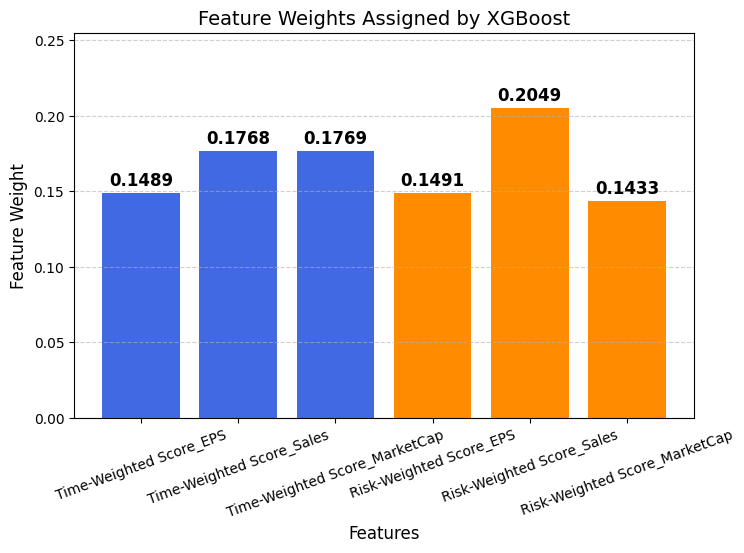

'/content/scores/final_growth_scores.csv'

In [ ]:
eps_time_df = compute_time_weighted_scores(eps_df)
sales_time_df = compute_time_weighted_scores(sales_df)
market_cap_time_df = compute_time_weighted_scores(market_cap_df)

eps_risk_df = compute_risk_weighted_scores(eps_df)
sales_risk_df = compute_risk_weighted_scores(sales_df)
market_cap_risk_df = compute_risk_weighted_scores(market_cap_df)

combined_time_df = eps_time_df.merge(sales_time_df, on="Stock", how="outer", suffixes=("_EPS", "_Sales"))
combined_time_df = combined_time_df.merge(market_cap_time_df, on="Stock", how="outer")
combined_time_df.rename(columns={"Time-Weighted Score": "Time-Weighted Score_MarketCap"}, inplace=True)

combined_risk_df = eps_risk_df.merge(sales_risk_df, on="Stock", how="outer", suffixes=("_EPS", "_Sales"))
combined_risk_df = combined_risk_df.merge(market_cap_risk_df, on="Stock", how="outer")
combined_risk_df.rename(columns={"Risk-Weighted Score": "Risk-Weighted Score_MarketCap"}, inplace=True)

full_scores_df = combined_time_df.merge(combined_risk_df, on="Stock", how="outer")

scaler = MinMaxScaler()
columns_to_scale = [
    "Time-Weighted Score_EPS", "Time-Weighted Score_Sales", "Time-Weighted Score_MarketCap",
    "Risk-Weighted Score_EPS", "Risk-Weighted Score_Sales", "Risk-Weighted Score_MarketCap"
]
full_scores_df[columns_to_scale] = scaler.fit_transform(full_scores_df[columns_to_scale])

np.random.seed(42)
y_train = np.random.rand(len(full_scores_df))

X_train = full_scores_df[columns_to_scale]
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0]
}

xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
grid_search = GridSearchCV(xgb_model, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_xgb = grid_search.best_estimator_
best_xgb.fit(X_train, y_train)

feature_weights = best_xgb.feature_importances_
feature_names = columns_to_scale

full_scores_df["Final Score"] = sum(full_scores_df[feature] * weight for feature, weight in zip(feature_names, feature_weights))

full_scores_df["Rank"] = full_scores_df["Final Score"].rank(method="min", ascending=False)
full_scores_df["Rank"] = full_scores_df["Rank"].fillna(len(full_scores_df)).astype(int)

full_scores_df["Normalized Score"] = 10 * ((len(full_scores_df) - full_scores_df["Rank"]) / (len(full_scores_df) - 1))

final_scores_path = "/content/scores/final_growth_scores.csv"
full_scores_df.to_csv(final_scores_path, index=False)

print("\n🔹 Best Hyperparameters Found by Grid Search:")
print(grid_search.best_params_)

colors = ["royalblue", "royalblue","royalblue", "darkorange","darkorange","darkorange"]
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(feature_names, feature_weights, color=colors)

for bar, weight in zip(bars, feature_weights):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, f"{weight:.4f}", ha="center", fontsize=12, fontweight="bold", color="black")

ax.set_ylabel("Feature Weight", fontsize=12)
ax.set_xlabel("Features", fontsize=12)
ax.set_title("Feature Weights Assigned by XGBoost", fontsize=14)
ax.set_ylim(0, max(feature_weights) + 0.05)
ax.grid(axis="y", linestyle="--", alpha=0.6)
plt.xticks(rotation=20)
plt.show()

final_scores_path

Computation of Risk Metrics

In [ ]:
close_df = pd.read_csv("/content/data/sample_dates_formated_close.csv")
close_df =filter_data_by_date(close_df,"DATE")

if 'Date' in close_df.columns:
    close_df['Date'] = pd.to_datetime(close_df['Date'])
    close_df.set_index('Date', inplace=True)

def calculate_risk_metrics(close_prices):
    returns = close_prices.pct_change().dropna()

    std_dev = returns.std()

    cumulative_max = close_prices.cummax()
    drawdown = (close_prices / cumulative_max) - 1
    max_drawdown = drawdown.min()

    threshold = max_drawdown * 0.95
    drawdown_count = (drawdown <= threshold).sum()

    return std_dev, max_drawdown, drawdown_count

risk_metrics = {
    "Stock": [],
    "Std_Dev": [],
    "Max_Drawdown": [],
    "Num_Drawdowns": []
}

for stock in close_df.columns:
    stock_prices = pd.to_numeric(close_df[stock], errors='coerce').dropna()

    if len(stock_prices) > 1:
        std_dev, max_drawdown, num_drawdowns = calculate_risk_metrics(stock_prices)
        risk_metrics["Stock"].append(stock)
        risk_metrics["Std_Dev"].append(std_dev)
        risk_metrics["Max_Drawdown"].append(max_drawdown)
        risk_metrics["Num_Drawdowns"].append(num_drawdowns)

risk_df = pd.DataFrame(risk_metrics)
output_path = "/content/scores/final_stock_risk_metrics.csv"
risk_df.to_csv(output_path, index=False)

print(f"Risk metrics saved successfully to {output_path}")

Risk metrics saved successfully to /content/scores/final_stock_risk_metrics.csv


Computation of Risk Scores


🔹 Best Hyperparameters Found by Grid Search:
{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}


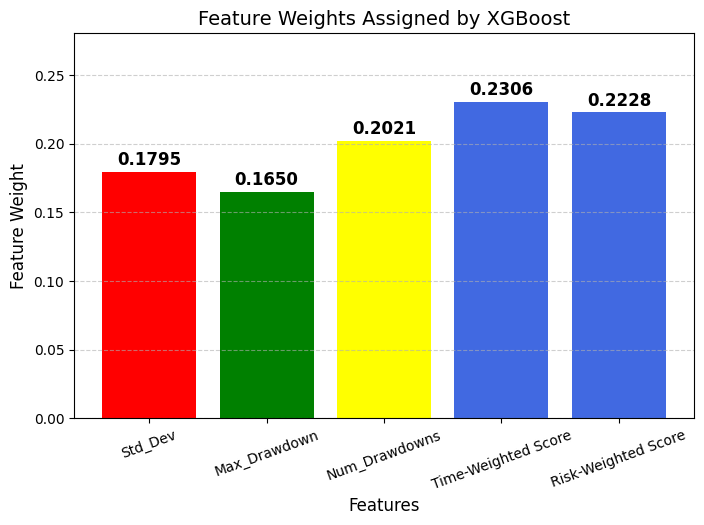

'/content/scores/final_combined_risk_scores.csv'

In [ ]:
risk_scores_df = pd.read_csv("/content/scores/final_stock_risk_metrics.csv")

debt_to_equity_time_df = compute_time_weighted_scores(debt_to_equity_df)
debt_to_equity_risk_df = compute_risk_weighted_scores(debt_to_equity_df)

combined_scores_df = risk_scores_df.merge(debt_to_equity_time_df, on="Stock", how="outer")
combined_scores_df = combined_scores_df.merge(debt_to_equity_risk_df, on="Stock", how="outer")

scaler = MinMaxScaler()
columns_to_scale = combined_scores_df.columns[1:]
combined_scores_df[columns_to_scale] = scaler.fit_transform(combined_scores_df[columns_to_scale])

np.random.seed(42)
y_train = np.random.rand(len(combined_scores_df))

X_train = combined_scores_df[columns_to_scale]
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0]
}

xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
grid_search = GridSearchCV(xgb_model, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_xgb = grid_search.best_estimator_
best_xgb.fit(X_train, y_train)

feature_weights = best_xgb.feature_importances_
feature_names = columns_to_scale

combined_scores_df["Final Risk Score"] = sum(combined_scores_df[feature] * weight for feature, weight in zip(feature_names, feature_weights))

combined_scores_df["Rank"] = combined_scores_df["Final Risk Score"].rank(method="min", ascending=True)
combined_scores_df["Rank"] = combined_scores_df["Rank"].fillna(len(combined_scores_df)).astype(int)

combined_scores_df["Normalized Score"] = 10 * ((len(combined_scores_df) - combined_scores_df["Rank"]) / (len(combined_scores_df) - 1))

final_scores_path = "/content/scores/final_combined_risk_scores.csv"
combined_scores_df.to_csv(final_scores_path, index=False)

print("\n🔹 Best Hyperparameters Found by Grid Search:")
print(grid_search.best_params_)

colors = ["red", "green", "yellow", "royalblue","royalblue"]
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(feature_names, feature_weights, color=colors)

for bar, weight in zip(bars, feature_weights):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, f"{weight:.4f}", ha="center", fontsize=12, fontweight="bold", color="black")

ax.set_ylabel("Feature Weight", fontsize=12)
ax.set_xlabel("Features", fontsize=12)
ax.set_title("Feature Weights Assigned by XGBoost", fontsize=14)
ax.set_ylim(0, max(feature_weights) + 0.05)
ax.grid(axis="y", linestyle="--", alpha=0.6)
plt.xticks(rotation=20)
plt.show()

final_scores_path

Computation of Returns and Scoring


🔹 Best Hyperparameters Found by Grid Search:
{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}


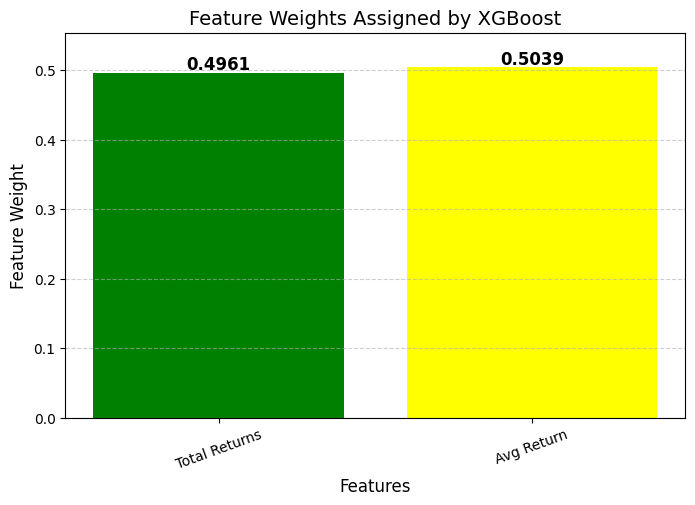

'/content/scores/return_analysis.csv'

In [ ]:

df = pd.read_csv("/content/data/sample_dates_formated_close.csv")
df =filter_data_by_date(df,"DATE")


df["DATE"] = pd.to_datetime(df["DATE"], format="%d-%m-%Y")

df.iloc[:, 1:] = df.iloc[:, 1:].apply(pd.to_numeric, errors='coerce')

stock_data = []

for stock in df.columns[1:]:
    available_data = df.loc[df[stock].notna(), ["DATE", stock]]

    if not available_data.empty:
        start_price = available_data[stock].iloc[0]
        end_price = available_data[stock].iloc[-1]
        years = math.ceil((available_data["DATE"].max() - available_data["DATE"].min()).days / 365)

        if start_price > 0:
            total_returns = ((end_price - start_price) / start_price) * 100 if years > 0 else 0
            avg_return = total_returns / years if years > 0 else 0
        else:
            total_returns = avg_return = 0
    else:
        years = total_returns = avg_return = 0

    stock_data.append([stock, years, total_returns, avg_return])

stock_df = pd.DataFrame(stock_data, columns=["Stock Name", "Years", "Total Returns", "Avg Return"])

stock_df.fillna(0, inplace=True)

y_train = np.random.rand(len(stock_df))
X_train = stock_df[["Total Returns", "Avg Return"]]

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0]
}

xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
grid_search = GridSearchCV(xgb_model, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_xgb = grid_search.best_estimator_
best_xgb.fit(X_train, y_train)

feature_weights = best_xgb.feature_importances_
feature_names = ["Total Returns", "Avg Return"]

stock_df["Final Risk Score"] = sum(stock_df[feature] * weight for feature, weight in zip(feature_names, feature_weights[1:]))

stock_df["Rank"] = stock_df["Final Risk Score"].rank(method="min", ascending=False).astype(int)
stock_df["Normalized Score"] = 10 * ((len(stock_df) - stock_df["Rank"]) / (len(stock_df) - 1))

output_file = "/content/scores/return_analysis.csv"
stock_df.to_csv(output_file, index=False)

print("\n🔹 Best Hyperparameters Found by Grid Search:")
print(grid_search.best_params_)

colors = ["green", "yellow"]
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(feature_names, feature_weights, color=colors)

for bar, weight in zip(bars, feature_weights):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, f"{weight:.4f}", ha="center", fontsize=12, fontweight="bold", color="black")

ax.set_ylabel("Feature Weight", fontsize=12)
ax.set_xlabel("Features", fontsize=12)
ax.set_title("Feature Weights Assigned by XGBoost", fontsize=14)
ax.set_ylim(0, max(feature_weights) + 0.05)
ax.grid(axis="y", linestyle="--", alpha=0.6)
plt.xticks(rotation=20)
plt.show()

output_file

Computation of Combined and Normalized scores

In [ ]:
file_paths = {
    "return": "/content/scores/return_analysis.csv",
    "valuation": "/content/scores/final_valuation_scores.csv",
    "profitability": "/content/scores/final_profitability_scores.csv",
    "liquidity": "/content/scores/final_liquidity_scores.csv",
    "growth": "/content/scores/final_growth_scores.csv",
    "risk": "/content/scores/final_combined_risk_scores.csv",
}

dfs = {key: pd.read_csv(path) for key, path in file_paths.items()}

{key: df.head() for key, df in dfs.items()}

{'return':                Stock Name  Years  Total Returns  Avg Return  Final Risk Score  \
 0        360 One Wam Ltd.      4      33.169415    8.292354         16.714031   
 1           3M India Ltd.     14    1076.100764   76.864340        542.245947   
 2        A B B India Ltd.     14     249.758832   17.839917        125.853190   
 3              A C C Ltd.     14     179.855579   12.846827         90.629021   
 4  A I A Engineering Ltd.     14     589.966375   42.140455        297.283383   
 
    Rank  Normalized Score  
 0   360          2.805611  
 1    94          8.136273  
 2   238          5.250501  
 3   265          4.709419  
 4   150          7.014028  ,
 'valuation':                     Stock  Time-Weighted Score_PE  Time-Weighted Score_PB  \
 0        360 One Wam Ltd.                0.001720                0.006853   
 1           3M India Ltd.                0.004379                0.014207   
 2        A B B India Ltd.                0.007399                0.012401

In [ ]:
weights = {
    "return": 0.20,
    "valuation": 0.15,
    "profitability": 0.15,
    "liquidity": 0.15,
    "growth": 0.15,
    "risk": 0.20,
}

merged_df = dfs["return"][["Stock Name", "Normalized Score"]].rename(columns={"Normalized Score": "return"})
for key in ["valuation", "profitability", "liquidity", "growth", "risk"]:
    score_col = "Normalized Score"
    stock_col = "Stock" if "Stock" in dfs[key].columns else "Stock Name"
    merged_df = merged_df.merge(dfs[key][[stock_col, score_col]], left_on="Stock Name", right_on=stock_col, how="inner")
    merged_df = merged_df.drop(columns=[stock_col]).rename(columns={score_col: key})

scaler = MinMaxScaler(feature_range=(0, 1))
score_columns = ["return", "valuation", "profitability", "liquidity", "growth", "risk"]
merged_df[score_columns] = scaler.fit_transform(merged_df[score_columns])
merged_df["Final Weighted Score"] = sum(merged_df[col] * weight for col, weight in weights.items())
merged_df["Final Normalized Score"] = 100 * (merged_df["Final Weighted Score"] / merged_df["Final Weighted Score"].max())
all_500_stocks = merged_df.sort_values(by="Final Normalized Score", ascending=False)
all_500_stocks.head(10)

,Stock Name,return,valuation,profitability,liquidity,growth,risk,Final Weighted Score,Final Normalized Score
363,Poonawalla Fincorp Ltd.,0.777555,0.837895,0.520408,0.978541,0.959920,0.919840,0.833993,100.000000
37,Apar Industries Ltd.,0.795591,0.907368,0.979592,0.924893,0.779559,0.625251,0.822880,98.667455
247,J B M Auto Ltd.,0.983968,0.585263,0.969388,0.972103,0.837675,0.585170,0.818492,98.141300
320,Muthoot Finance Ltd.,0.665331,0.882105,0.646939,0.772532,0.995992,0.809619,0.789625,94.680022
386,Redington Ltd.,0.651303,0.934737,0.993878,0.969957,0.895792,0.442886,0.787992,94.484207
250,J K Tyre & Inds. Ltd.,0.661323,0.850526,0.887755,0.997854,0.735471,0.673347,0.787675,94.446161
381,Ramkrishna Forgings Ltd.,0.831663,0.661053,0.895918,0.946352,0.809619,0.587174,0.780709,93.610906
104,Century Plyboards (India) Ltd.,0.809619,0.717895,0.869388,0.824034,0.881764,0.571142,0.770114,92.340572
279,Kei Industries Ltd.,0.935872,0.722105,0.867347,0.712446,0.651303,0.689379,0.768030,92.090680
42,Asahi India Glass Ltd.,0.747495,0.454737,0.730612,0.937768,0.831663,0.853707,0.763458,91.542391


In [ ]:
output_folder = "/content/final_results/"
os.makedirs(output_folder, exist_ok=True)
output_file = output_folder + "all_500_stocks.csv"
all_500_stocks.to_csv(output_file, index=False)
output_file

'/content/final_results/all_500_stocks.csv'

Clustering NIFTY500 stocks based on Industries

In [ ]:
industry_file = "/content/ind_nifty500list.csv"
stocks_file = "/content/final_results/all_500_stocks.csv"
output_folder = "/content/final_results/industries_clustered/"

os.makedirs(output_folder, exist_ok=True)

df_industries = pd.read_csv(industry_file)
df_stocks = pd.read_csv(stocks_file)

df = pd.merge(df_industries, df_stocks, left_on="Company Name", right_on="Stock Name", how="inner")

le = LabelEncoder()
df["Industry_Code"] = le.fit_transform(df["Industry"])

num_clusters = len(df["Industry"].unique())
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
df["Cluster"] = kmeans.fit_predict(df[["Industry_Code"]])

for industry, industry_df in df.groupby("Industry"):
    industry_file = os.path.join(output_folder, f"{industry.replace(' ', '_')}.csv")
    industry_df.to_csv(industry_file, index=False)

print(f"Clustering completed! Industry-wise files saved in: {output_folder}")

Clustering completed! Industry-wise files saved in: /content/final_results/industries_clustered/


<ipython-input-224-b46965e1e85e>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=industry_counts.index, y=industry_counts.values, palette="viridis")


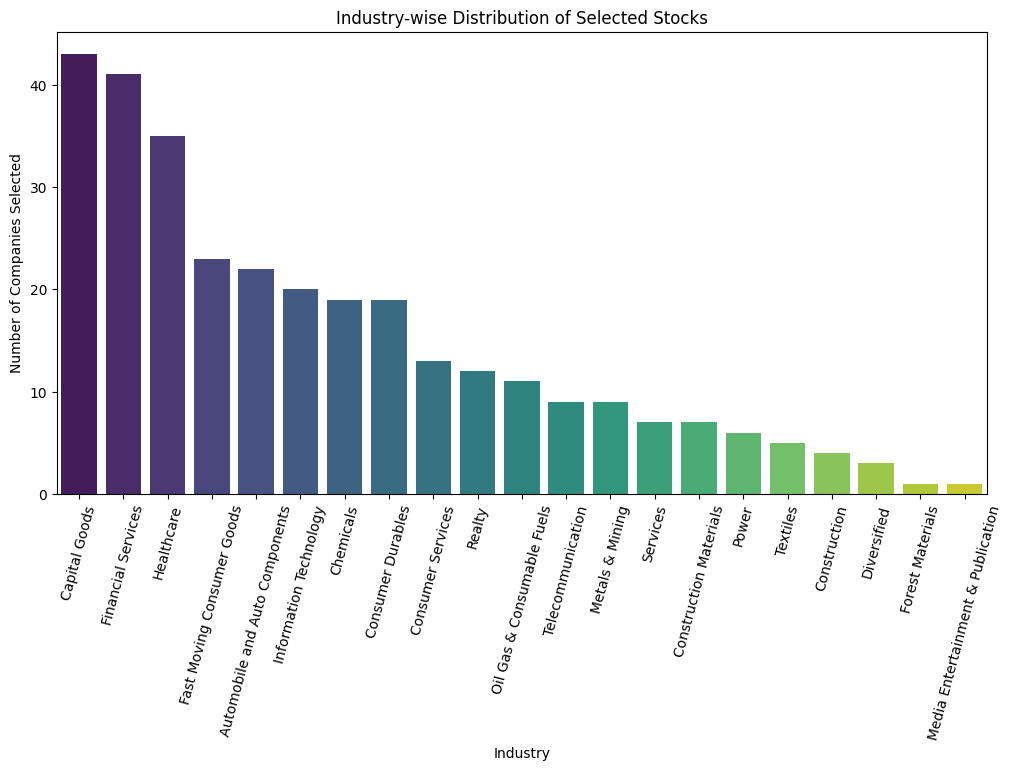

In [ ]:
plt.figure(figsize=(12, 6))
industry_counts = df["Industry"].value_counts()
sns.barplot(x=industry_counts.index, y=industry_counts.values, palette="viridis")
plt.xticks(rotation=75)
plt.xlabel("Industry")
plt.ylabel("Number of Companies Selected")
plt.title("Industry-wise Distribution of Selected Stocks")
plt.show()


Industry Market Cap Weightage

Top 150 companies selected and saved successfully at /content/final_results/market_top_150_companies.csv!


<ipython-input-225-19af7b1fd3f9>:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=industry_counts.index, y=industry_counts.values, palette="viridis")


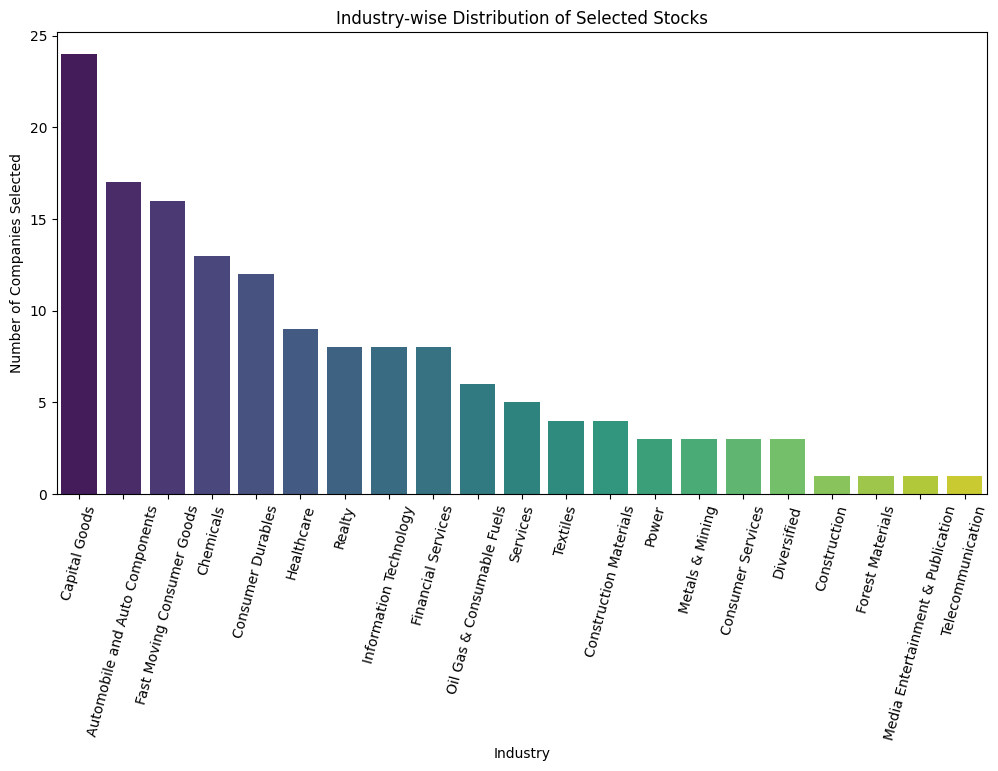

In [ ]:
input_file = "/content/final_results/all_500_stocks.csv"
industry_file = "/content/ind_nifty500list.csv"
output_file = "/content/final_results/market_top_150_companies.csv"

df_scores = pd.read_csv(input_file)
df_industries = pd.read_csv(industry_file)

df = pd.merge(df_industries, df_scores, left_on="Company Name", right_on="Stock Name", how="inner")

industry_weightage = {
    "Financial Services": 18.6, "Capital Goods": 12.2, "Healthcare": 9.6,
    "Automobile and Auto Components": 6.8, "Chemicals": 6.6,
    "Fast Moving Consumer Goods": 6.2, "Information Technology": 5.4,
    "Consumer Services": 4.4, "Consumer Durables": 4.4,
    "Oil Gas & Consumable Fuels": 3.6, "Services": 3.2, "Metals & Mining": 3.0,
    "Construction": 3.0, "Realty": 2.6, "Power": 2.6,
    "Construction Materials": 2.4, "Telecommunication": 2.2,
    "Textiles": 1.4, "Media Entertainment & Publication": 1.0,
    "Diversified": 0.6, "Forest Materials": 0.2
}

df["Industry Weightage"] = df["Industry"].map(industry_weightage).fillna(0)

total_weight = df["Industry Weightage"].sum()

df["Industry Slots"] = (df["Industry Weightage"] / total_weight * 150)

df["Industry Slots"] = df["Industry Slots"].apply(lambda x: max(1, round(x))).astype(int)

df = df.sort_values(by="Final Normalized Score", ascending=False)

selected_companies = []
total_selected = 0

for industry, slots in df.groupby("Industry")["Industry Slots"].first().items():
    top_companies = df[df["Industry"] == industry].head(slots)
    selected_companies.append(top_companies)
    total_selected += len(top_companies)

final_df = pd.concat(selected_companies)

if total_selected > 150:
    final_df = final_df.head(150)
elif total_selected < 150:
    remaining_slots = 150 - total_selected
    additional_companies = df[~df["Company Name"].isin(final_df["Company Name"])].head(remaining_slots)
    final_df = pd.concat([final_df, additional_companies])

final_df.to_csv(output_file, index=False)

print(f"Top 150 companies selected and saved successfully at {output_file}!")

plt.figure(figsize=(12, 6))
industry_counts = final_df["Industry"].value_counts()
sns.barplot(x=industry_counts.index, y=industry_counts.values, palette="viridis")
plt.xticks(rotation=75)
plt.xlabel("Industry")
plt.ylabel("Number of Companies Selected")
plt.title("Industry-wise Distribution of Selected Stocks")
plt.show()

Equal Weightage

Top 150 companies selected and saved successfully!


<ipython-input-226-ae05c3878ea4>:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=industry_counts.index, y=industry_counts.values, palette="viridis")


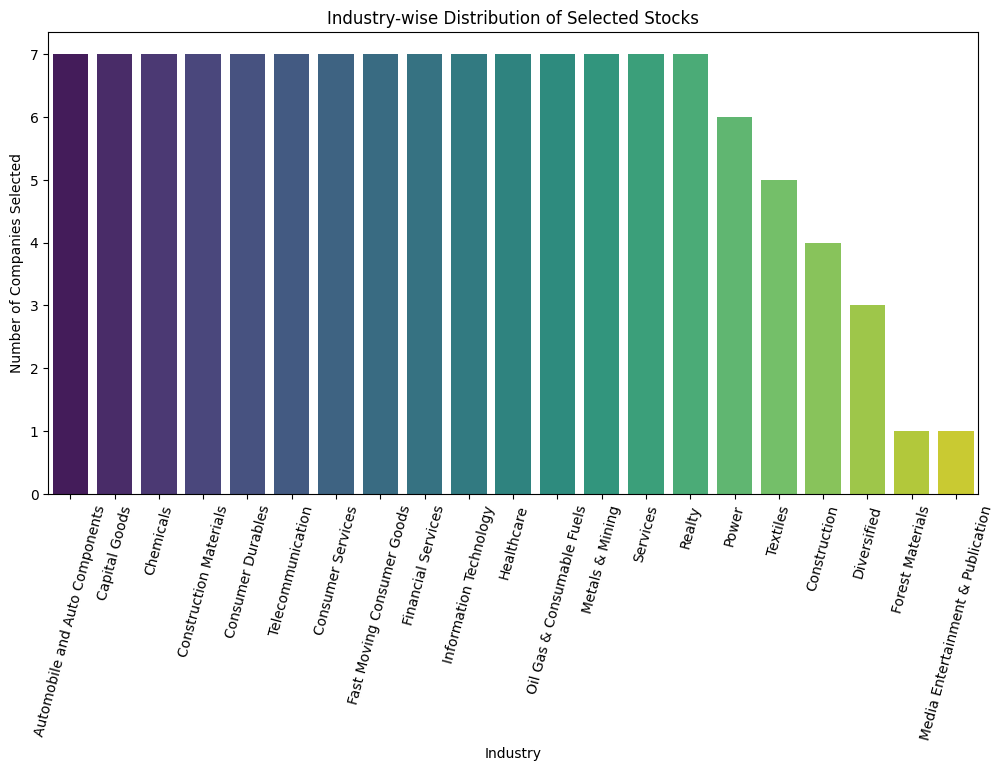

In [ ]:
input_file = "/content/final_results/all_500_stocks.csv"
industry_file = "/content/ind_nifty500list.csv"

df_scores = pd.read_csv(input_file)
df_industries = pd.read_csv(industry_file)

df = pd.merge(df_industries, df_scores, left_on="Company Name", right_on="Stock Name", how="inner")

industry_weightage = {
    "Financial Services": 4.76,
    "Capital Goods": 4.76,
    "Healthcare": 4.76,
    "Automobile and Auto Components": 4.76,
    "Chemicals": 4.76,
    "Fast Moving Consumer Goods": 4.76,
    "Information Technology": 4.76,
    "Consumer Services": 4.76,
    "Consumer Durables": 4.76,
    "Oil Gas & Consumable Fuels": 4.76,
    "Services": 4.76,
    "Metals & Mining": 4.76,
    "Construction": 4.76,
    "Realty": 4.76,
    "Power": 4.76,
    "Construction Materials": 4.76,
    "Telecommunication": 4.76,
    "Textiles": 4.76,
    "Media Entertainment & Publication": 4.76,
    "Diversified": 4.76,
    "Forest Materials": 4.76
}

df["Industry Weightage"] = df["Industry"].map(industry_weightage)

total_weight = sum(industry_weightage.values())
df["Industry Slots"] = (df["Industry Weightage"] / total_weight * 150).round().astype(int)

df = df.sort_values(by="Final Normalized Score", ascending=False)

selected_companies = []
for industry, slots in df.groupby("Industry")["Industry Slots"].first().items():
    top_companies = df[df["Industry"] == industry].head(slots)
    selected_companies.append(top_companies)

final_df = pd.concat(selected_companies).head(150)

final_df.to_csv("/content/final_results/equal_top_150_companies.csv", index=False)

print("Top 150 companies selected and saved successfully!")

plt.figure(figsize=(12, 6))
industry_counts = final_df["Industry"].value_counts()
sns.barplot(x=industry_counts.index, y=industry_counts.values, palette="viridis")
plt.xticks(rotation=75)
plt.xlabel("Industry")
plt.ylabel("Number of Companies Selected")
plt.title("Industry-wise Distribution of Selected Stocks")
plt.show()

Computation of Sharpe Ratio

In [ ]:
def filter_data_by_date(df, date_col="DATE", max_year=2021):
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce", dayfirst=True)
    df = df[df[date_col].notna()]
    df = df[df[date_col].dt.year <= max_year]
    return df

industry_df = pd.read_csv("/content/ind_nifty500list.csv")
price_df = pd.read_csv("/content/data/sample_dates_formated_close.csv")

price_df = filter_data_by_date(price_df, "DATE", max_year=2021)

price_df.loc[:, price_df.columns != "DATE"] = price_df.loc[:, price_df.columns != "DATE"].apply(pd.to_numeric, errors='coerce')

returns_df = price_df.set_index("DATE").pct_change(fill_method=None).dropna(how="all")
print("\nLast 5 rows of filtered price_df:")
print(price_df.tail())

industry_mapping = industry_df.set_index("Company Name")["Industry"].to_dict()

industry_returns = {}
for stock in returns_df.columns:
    industry = industry_mapping.get(stock, "Unknown")
    if industry not in industry_returns:
        industry_returns[industry] = []
    industry_returns[industry].append(returns_df[stock])

industry_stats = {}
risk_free_rate = 0.0003

for industry, stock_returns in industry_returns.items():
    industry_returns_df = pd.concat(stock_returns, axis=1)
    mean_return = industry_returns_df.mean(axis=1).mean()
    std_dev = industry_returns_df.mean(axis=1).std()

    sharpe_ratio = (mean_return - risk_free_rate) / std_dev if std_dev != 0 else np.nan
    industry_stats[industry] = sharpe_ratio

industry_sharpe_df = pd.DataFrame(list(industry_stats.items()), columns=["Industry", "Sharpe Ratio"])
industry_sharpe_df.dropna(inplace=True)

sharpe_min, sharpe_max = industry_sharpe_df["Sharpe Ratio"].min(), industry_sharpe_df["Sharpe Ratio"].max()
industry_sharpe_df["Normalized Score"] = (industry_sharpe_df["Sharpe Ratio"] - sharpe_min) / (sharpe_max - sharpe_min)

total_score = industry_sharpe_df["Normalized Score"].sum()
industry_sharpe_df["Normalized Score"] = industry_sharpe_df["Normalized Score"] * (100 / total_score)
print(industry_sharpe_df.sort_values(by="Sharpe Ratio", ascending=False))

industry_sharpe_df.to_csv("industry_sharpe_ratios_scaled.csv", index=False)


Last 5 rows of filtered price_df:
          DATE 360 One Wam Ltd.  3M India Ltd.  A B B India Ltd.  A C C Ltd.  \
621 2021-11-27           382.41       25185.00           1995.00     2311.50   
622 2021-12-04           373.55       25809.90           2078.40     2262.20   
623 2021-12-11           367.56       25257.65           2264.40     2315.55   
624 2021-12-18            337.3       24536.10           2199.75     2215.05   
625 2021-12-25            351.8       25237.85           2244.55     2126.05   

     A I A Engineering Ltd. A P L Apollo Tubes Ltd.  \
621                 1859.35                   887.1   
622                 1840.55                  925.35   
623                 1863.85                  985.25   
624                 1826.25                 1024.15   
625                 1803.10                  1008.5   

    A U Small Finance Bank Ltd. Aadhar Housing Finance Ltd.  \
621                      563.95                         NaN   
622                      56

Maximum Sharpe Ratio Portfolio

Top 150 companies selected and saved successfully!


<ipython-input-228-de3a52f0e748>:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=industry_counts.index, y=industry_counts.values, palette="viridis")


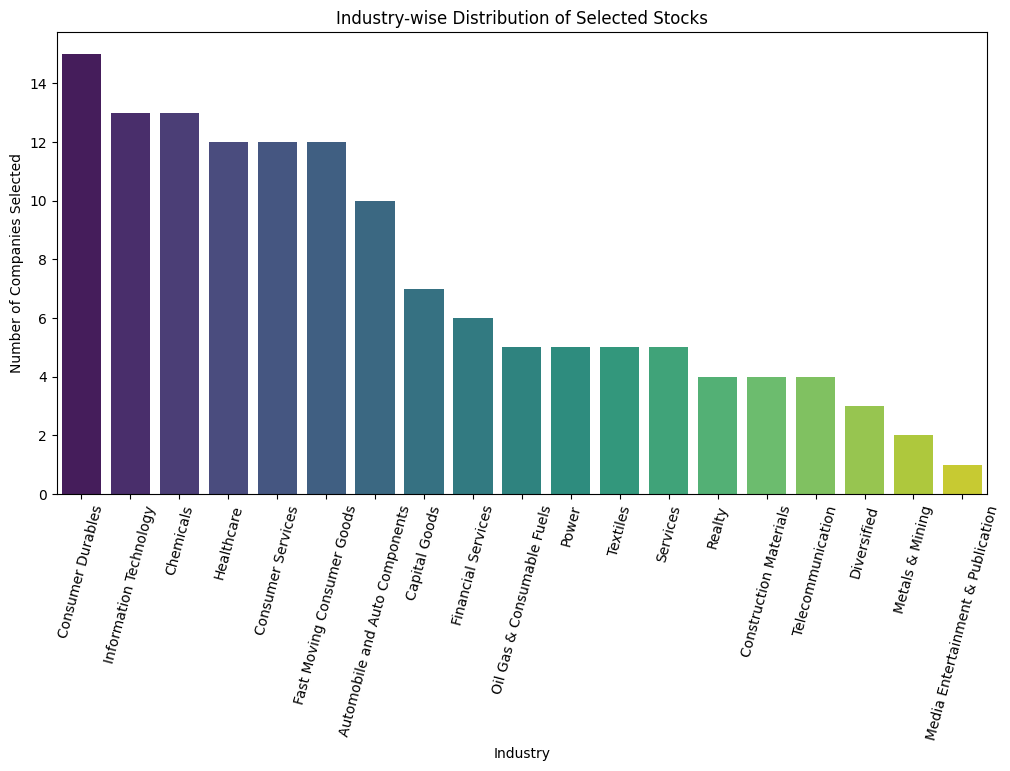

In [ ]:
input_file = "/content/final_results/all_500_stocks.csv"
industry_file = "/content/ind_nifty500list.csv"

df_scores = pd.read_csv(input_file)
df_industries = pd.read_csv(industry_file)

df = pd.merge(df_industries, df_scores, left_on="Company Name", right_on="Stock Name", how="inner")

industry_weightage = {
    "Consumer Durables": 10.071451,
    "Information Technology": 8.551481,
    "Chemicals": 8.458200,
    "Consumer Services": 8.229477,
    "Healthcare": 8.176106,
    "Fast Moving Consumer Goods": 7.928981,
    "Automobile and Auto Components": 6.379466,
    "Textiles": 5.806676,
    "Capital Goods": 4.914385,
    "Unknown": 4.764401,
    "Financial Services": 3.790026,
    "Diversified": 3.470030,
    "Oil Gas & Consumable Fuels": 3.394718,
    "Services": 3.053163,
    "Power": 3.051427,
    "Realty": 2.886406,
    "Construction Materials": 2.480245,
    "Telecommunication": 2.415000,
    "Metals & Mining": 1.331981,
    "Media Entertainment & Publication": 0.594125,
    "Forest Materials": 0.252255,
    "Construction": 0.000000
}

df["Industry Weightage"] = df["Industry"].map(industry_weightage)
total_weight = sum(industry_weightage.values())
df["Industry Slots"] = (df["Industry Weightage"] / total_weight * 150).round().astype(int)
df = df.sort_values(by="Final Normalized Score", ascending=False)

selected_companies = []
for industry, slots in df.groupby("Industry")["Industry Slots"].first().items():
    top_companies = df[df["Industry"] == industry].head(slots)
    selected_companies.append(top_companies)

final_df = pd.concat(selected_companies).head(150)
final_df.to_csv("/content/final_results/sharpe_top_150_companies.csv", index=False)

print("Top 150 companies selected and saved successfully!")

plt.figure(figsize=(12, 6))
industry_counts = final_df["Industry"].value_counts()
sns.barplot(x=industry_counts.index, y=industry_counts.values, palette="viridis")
plt.xticks(rotation=75)
plt.xlabel("Industry")
plt.ylabel("Number of Companies Selected")
plt.title("Industry-wise Distribution of Selected Stocks")
plt.show()

In [ ]:
pip install gym torch numpy pandas matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 81.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 810.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import gym

Top 50 Companies Data Shape: (50, 8)
Nifty 50 Stocks Data Shape: (47, 8)
Using device: cpu


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64, 50])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode 10: Total Reward = 32.9228, Epsilon = 0.9044
Episode 20: Total Reward = 33.7183, Epsilon = 0.8179
Episode 30: Total Reward = 33.3784, Epsilon = 0.7397
Episode 40: Total Reward = 32.6266, Epsilon = 0.6690
Episode 50: Total Reward = 31.9710, Epsilon = 0.6050
Episode 60: Total Reward = 32.4445, Epsilon = 0.5472
Episode 70: Total Reward = 32.0352, Epsilon = 0.4948
Episode 80: Total Reward = 30.3326, Epsilon = 0.4475
Episode 90: Total Reward = 30.9490, Epsilon = 0.4047
Episode 100: Total Reward = 30.4982, Epsilon = 0.3660
Episode 110: Total Reward = 30.8515, Epsilon = 0.3310
Episode 120: Total Reward = 30.2527, Epsilon = 0.2994
Episode 130: Total Reward = 30.0754, Epsilon = 0.2708
Episode 140: Total Reward = 30.4537, Epsilon = 0.2449
Episode 150: Total Reward = 30.8673, Epsilon = 0.2215
Episode 160: Total Reward = 30.2763, Epsilon = 0.2003
Episode 170: Total Reward = 30.0652, Epsilon = 0.1811
Episode 180: Total Reward = 29.4893, Epsilon = 0.1638
Episode 190: Total Reward = 30.3545, 

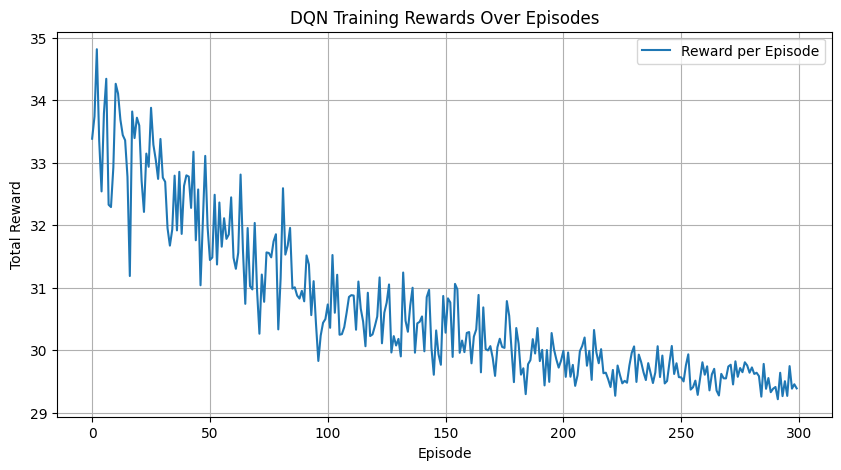

In [ ]:
class PortfolioEvaluator:
    @staticmethod
    def calculate_metrics(stock_data):
        metrics = {
            'return': np.mean(stock_data[:, 0]) if stock_data.size > 0 else 0,
            'risk': np.std(stock_data[:, 0]) if stock_data.size > 0 else 0,
            'profitability': np.mean(stock_data[:, 2]) if stock_data.size > 0 else 0,
            'liquidity': np.mean(stock_data[:, 3]) if stock_data.size > 0 else 0,
            'growth': np.mean(stock_data[:, 4]) if stock_data.size > 0 else 0,
            'risk_score': np.mean(stock_data[:, 5]) if stock_data.size > 0 else 0,
            'valuation': np.mean(stock_data[:, 1]) if stock_data.size > 0 else 0
        }

        risk_free_rate = 0.05
        metrics['sharpe_ratio'] = (metrics['return'] - risk_free_rate) / metrics['risk'] if metrics['risk'] != 0 else 0

        return metrics

class StockDataPreprocessor:
    @staticmethod
    def preprocess_stock_data(file_path):
        try:
            df_stock = pd.read_csv(file_path, usecols=[
                "Stock Name", "return", "valuation", "profitability",
                "liquidity", "growth", "risk",
                "Final Weighted Score", "Final Normalized Score"
            ])
        except Exception as e:
            print(f"Error reading CSV file: {e}")
            return None, None

        nifty_50_stocks = [
            "Adani Enterprises Ltd.", "Adani Ports & Special Economic Zone Ltd.", "Apollo Hospitals Enterprise Ltd.",
            "Asian Paints Ltd.", "Axis Bank Ltd.", "Bajaj Auto Ltd.", "Bajaj Finance Ltd.", "Bajaj Finserv Ltd.",
            "Bharti Airtel Ltd.", "Britannia Industries Ltd.", "Cipla Ltd.", "Coal India Ltd.", "Dr. Reddy'S Laboratories Ltd.",
            "Eicher Motors Ltd.", "Grasim Industries Ltd.", "H C L Technologies Ltd.", "H D F C Bank Ltd.",
            "Hindustan Unilever Ltd.", "I T C Ltd.", "Infosys Ltd.", "J S W Steel Ltd.", "Kotak Mahindra Bank Ltd.",
            "Larsen & Toubro Ltd.", "Ltimindtree Ltd.", "Mahindra & Mahindra Ltd.", "Maruti Suzuki India Ltd.",
            "Nestle India Ltd.", "N T P C Ltd.", "Oil & Natural Gas Corpn. Ltd.", "Power Grid Corpn. Of India Ltd.",
            "Reliance Industries Ltd.", "S B I Life Insurance Co. Ltd.", "State Bank Of India",
            "Sun Pharmaceutical Inds. Ltd.", "Tata Consultancy Services Ltd.", "Tata Consumer Products Ltd.",
            "Tata Steel Ltd.", "Tech Mahindra Ltd.", "Titan Company Ltd.", "Ultratech Cement Ltd.", "U P L Ltd.",
            "Wipro Ltd.", "Bharat Electronics Ltd.", "Bharat Petroleum Corpn. Ltd.", "H D F C Life Insurance Co. Ltd.",
            "Hero Motocorp Ltd.", "Hindalco Industries Ltd.", "I C I C I Bank Ltd.", "Indusind Bank Ltd."
        ]

        df_nifty50 = df_stock[df_stock["Stock Name"].isin(nifty_50_stocks)]
        df_stock_sorted = df_stock.sort_values("Final Normalized Score", ascending=False)
        df_top50 = df_stock_sorted.head(50)
        return df_top50, df_nifty50

class StockSelectionEnv(gym.Env):
    def __init__(self, stock_data, nifty50_data, top50_df):
        super(StockSelectionEnv, self).__init__()

        self.stock_data = stock_data
        self.nifty50_data = nifty50_data
        self.top50_df = top50_df
        self.n_stocks = stock_data.shape[0]
        self.action_space = gym.spaces.MultiBinary(self.n_stocks)
        self.observation_space = gym.spaces.Box(
            low=0, high=1, shape=(self.n_stocks,), dtype=np.float32
        )

        self.reset()

    def step(self, action):
        action_int = action.astype(int)
        if np.sum(action_int) > 50:
            weights = self.top50_df["Final Normalized Score"].values
            sorted_indices = np.argsort(weights)[::-1]
            action_int = np.zeros_like(action_int)
            action_int[sorted_indices[:50]] = 1

        elif np.sum(action_int) < 50:
            selected_mask = action_int == 1
            unselected_mask = action_int == 0

            unselected_weights = self.top50_df[unselected_mask]["Final Normalized Score"].values
            unselected_sorted_indices = np.argsort(unselected_weights)[::-1]

            additional_stocks_needed = 50 - np.sum(action_int)
            additional_stocks_needed = min(additional_stocks_needed, len(unselected_sorted_indices))

            for idx in unselected_sorted_indices[:additional_stocks_needed]:
                action_int[idx] = 1

        self.selected_stocks = action_int.astype(np.float32)

        selected_stock_data = self.stock_data[np.where(self.selected_stocks == 1)[0]]

        portfolio_metrics = PortfolioEvaluator.calculate_metrics(selected_stock_data)
        nifty50_metrics = PortfolioEvaluator.calculate_metrics(self.nifty50_data)

        reward_components = {
            'return_diff': portfolio_metrics['return'] - nifty50_metrics['return'],
            'sharpe_ratio_diff': portfolio_metrics['sharpe_ratio'] - nifty50_metrics['sharpe_ratio'],
            'profitability_diff': portfolio_metrics['profitability'] - nifty50_metrics['profitability'],
            'risk_diff': -abs(portfolio_metrics['risk'] - nifty50_metrics['risk']),
            'growth_diff': portfolio_metrics['growth'] - nifty50_metrics['growth']
        }

        weights = {
            'return_diff': 0.3,
            'sharpe_ratio_diff': 0.2,
            'profitability_diff': 0.15,
            'risk_diff': 0.2,
            'growth_diff': 0.15
        }

        reward = sum(reward_components[key] * weights[key] for key in reward_components)

        self.portfolio_metrics = portfolio_metrics
        self.nifty50_metrics = nifty50_metrics

        return self.selected_stocks, reward, False, {
            'portfolio_metrics': portfolio_metrics,
            'nifty50_metrics': nifty50_metrics,
            'reward_components': reward_components
        }

    def reset(self):
        self.current_step = 0
        self.selected_stocks = np.zeros(self.n_stocks, dtype=np.float32)
        num_initial_stocks = min(10, self.n_stocks)
        initial_indices = np.random.choice(self.n_stocks, num_initial_stocks, replace=False)
        self.selected_stocks[initial_indices] = 1
        return self.selected_stocks

class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.network(x)

def train_dqn(env, epochs=300, steps_per_epoch=100):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    model = DQN(env.n_stocks, env.n_stocks).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.MSELoss()

    memory = deque(maxlen=2000)

    gamma = 0.99
    epsilon = 1.0
    epsilon_decay = 0.99
    min_epsilon = 0.01
    batch_size = 64

    rewards_history = []
    portfolio_metrics_history = []
    nifty50_metrics_history = []

    for episode in range(epochs):
        state = env.reset()
        total_reward = 0

        for _ in range(steps_per_epoch):
            state_tensor = torch.tensor(state, dtype=torch.float32, device=device)

            with torch.no_grad():
                action_probs = model(state_tensor)

            if np.random.rand() < epsilon:
                action = (np.random.rand(env.n_stocks) < 0.5).astype(int)
            else:
                action = (action_probs.cpu().numpy() > 0.5).astype(int)

            next_state, reward, done, info = env.step(action)

            memory.append((state, action, reward, next_state))
            portfolio_metrics_history.append(info['portfolio_metrics'])
            nifty50_metrics_history.append(info['nifty50_metrics'])

            if len(memory) > batch_size:
                batch = random.sample(memory, batch_size)
                states, actions, rewards, next_states = zip(*batch)

                states_tensor = torch.tensor(states, dtype=torch.float32, device=device)
                rewards_tensor = torch.tensor(rewards, dtype=torch.float32, device=device)
                next_states_tensor = torch.tensor(next_states, dtype=torch.float32, device=device)

                q_values = model(states_tensor)
                next_q_values = model(next_states_tensor).detach()

                target_q_values = rewards_tensor + gamma * next_q_values.max(dim=1)[0]

                loss = loss_fn(q_values, target_q_values.unsqueeze(1))
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            total_reward += reward
            state = next_state

        epsilon = max(min_epsilon, epsilon * epsilon_decay)
        rewards_history.append(total_reward)
        if (episode + 1) % 10 == 0:
            print(f"Episode {episode+1}: Total Reward = {total_reward:.4f}, Epsilon = {epsilon:.4f}")

    plt.figure(figsize=(10, 5))
    plt.plot(rewards_history, label="Reward per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("DQN Training Rewards Over Episodes")
    plt.legend()
    plt.grid()
    plt.show()

    return model, rewards_history, portfolio_metrics_history, nifty50_metrics_history

def main():
    top_companies_csv_path = "/content/final_results/market_top_150_companies.csv"
    all_stocks_csv_path = "/content/final_results/all_500_stocks.csv"
    df_top50, _ = StockDataPreprocessor.preprocess_stock_data(top_companies_csv_path)
    _, df_nifty50 = StockDataPreprocessor.preprocess_stock_data(all_stocks_csv_path)

    if df_top50 is None or df_nifty50 is None:
        print("Failed to load stock data. Please check the CSV file paths.")
        return

    df_top50_prices = df_top50.drop(columns=["Stock Name"]).to_numpy(dtype=np.float32)
    df_nifty50_prices = df_nifty50.drop(columns=["Stock Name"]).to_numpy(dtype=np.float32)

    print("Top 50 Companies Data Shape:", df_top50_prices.shape)
    print("Nifty 50 Stocks Data Shape:", df_nifty50_prices.shape)

    env = StockSelectionEnv(df_top50_prices, df_nifty50_prices, df_top50)
    trained_model, rewards, portfolio_metrics, nifty50_metrics = train_dqn(env)

    state = env.reset()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    state_tensor = torch.tensor(state, dtype=torch.float32, device=device)

    with torch.no_grad():
        best_action = trained_model(state_tensor).cpu().numpy()

    selected_stocks = np.where(best_action > 0.5)[0]

if __name__ == "__main__":
    main()

In [ ]:
folder_path = "/content/portfolios"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    print(f"Folder '{folder_path}' created successfully.")
else:
    print(f"Folder '{folder_path}' already exists.")

Folder '/content/portfolios' already exists.


In [ ]:
def save_top50_to_csv(df_top50, output_path="top_50_companies.csv"):
    try:
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        df_top50.to_csv(output_path, index=False)
        print(f"Top 50 companies saved to {output_path}")
    except Exception as e:
        print(f"Error saving CSV file: {e}")

top_companies_csv_path = "/content/final_results/market_top_150_companies.csv"
df_top50, _ = StockDataPreprocessor.preprocess_stock_data(top_companies_csv_path)

if df_top50 is not None:
    save_top50_to_csv(df_top50, "/content/portfolios/market_top_50_companies.csv")

Top 50 companies saved to /content/portfolios/market_top_50_companies.csv


Top 50 Companies Data Shape: (50, 8)
Nifty 50 Stocks Data Shape: (47, 8)
Using device: cpu


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64, 50])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode 10: Total Reward = 30.9926, Epsilon = 0.9044
Episode 20: Total Reward = 29.3119, Epsilon = 0.8179
Episode 30: Total Reward = 28.9118, Epsilon = 0.7397
Episode 40: Total Reward = 27.0248, Epsilon = 0.6690
Episode 50: Total Reward = 27.5122, Epsilon = 0.6050
Episode 60: Total Reward = 27.0452, Epsilon = 0.5472
Episode 70: Total Reward = 26.5856, Epsilon = 0.4948
Episode 80: Total Reward = 27.5881, Epsilon = 0.4475
Episode 90: Total Reward = 25.9007, Epsilon = 0.4047
Episode 100: Total Reward = 25.8813, Epsilon = 0.3660
Episode 110: Total Reward = 26.1143, Epsilon = 0.3310
Episode 120: Total Reward = 26.1017, Epsilon = 0.2994
Episode 130: Total Reward = 25.6492, Epsilon = 0.2708
Episode 140: Total Reward = 25.4295, Epsilon = 0.2449
Episode 150: Total Reward = 25.8100, Epsilon = 0.2215
Episode 160: Total Reward = 25.3579, Epsilon = 0.2003
Episode 170: Total Reward = 25.5778, Epsilon = 0.1811
Episode 180: Total Reward = 25.7021, Epsilon = 0.1638
Episode 190: Total Reward = 24.6525, 

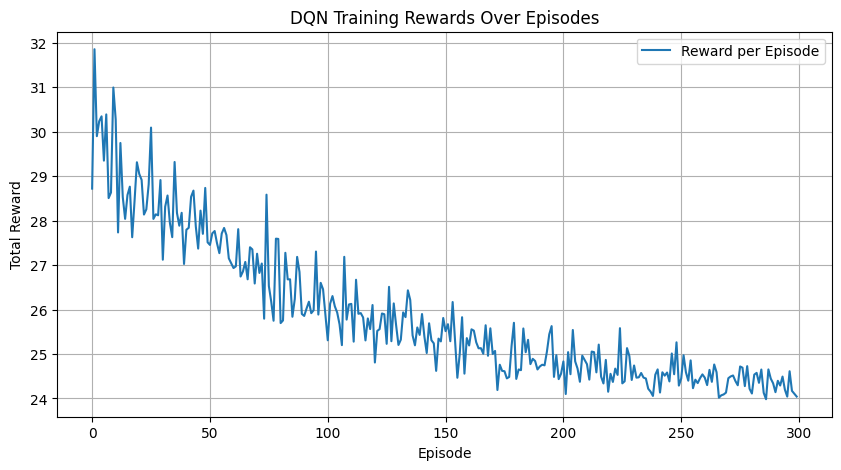

In [ ]:
class PortfolioEvaluator:
    @staticmethod
    def calculate_metrics(stock_data):
        metrics = {
            'return': np.mean(stock_data[:, 0]) if stock_data.size > 0 else 0,
            'risk': np.std(stock_data[:, 0]) if stock_data.size > 0 else 0,
            'profitability': np.mean(stock_data[:, 2]) if stock_data.size > 0 else 0,
            'liquidity': np.mean(stock_data[:, 3]) if stock_data.size > 0 else 0,
            'growth': np.mean(stock_data[:, 4]) if stock_data.size > 0 else 0,
            'risk_score': np.mean(stock_data[:, 5]) if stock_data.size > 0 else 0,
            'valuation': np.mean(stock_data[:, 1]) if stock_data.size > 0 else 0
        }

        risk_free_rate = 0.05
        metrics['sharpe_ratio'] = (metrics['return'] - risk_free_rate) / metrics['risk'] if metrics['risk'] != 0 else 0
        return metrics

class StockDataPreprocessor:
    @staticmethod
    def preprocess_stock_data(file_path):
        try:
            df_stock = pd.read_csv(file_path, usecols=[
                "Stock Name", "return", "valuation", "profitability",
                "liquidity", "growth", "risk",
                "Final Weighted Score", "Final Normalized Score"
            ])
        except Exception as e:
            print(f"Error reading CSV file: {e}")
            return None, None

        nifty_50_stocks = [
            "Adani Enterprises Ltd.", "Adani Ports & Special Economic Zone Ltd.", "Apollo Hospitals Enterprise Ltd.",
            "Asian Paints Ltd.", "Axis Bank Ltd.", "Bajaj Auto Ltd.", "Bajaj Finance Ltd.", "Bajaj Finserv Ltd.",
            "Bharti Airtel Ltd.", "Britannia Industries Ltd.", "Cipla Ltd.", "Coal India Ltd.", "Dr. Reddy'S Laboratories Ltd.",
            "Eicher Motors Ltd.", "Grasim Industries Ltd.", "H C L Technologies Ltd.", "H D F C Bank Ltd.",
            "Hindustan Unilever Ltd.", "I T C Ltd.", "Infosys Ltd.", "J S W Steel Ltd.", "Kotak Mahindra Bank Ltd.",
            "Larsen & Toubro Ltd.", "Ltimindtree Ltd.", "Mahindra & Mahindra Ltd.", "Maruti Suzuki India Ltd.",
            "Nestle India Ltd.", "N T P C Ltd.", "Oil & Natural Gas Corpn. Ltd.", "Power Grid Corpn. Of India Ltd.",
            "Reliance Industries Ltd.", "S B I Life Insurance Co. Ltd.", "State Bank Of India",
            "Sun Pharmaceutical Inds. Ltd.", "Tata Consultancy Services Ltd.", "Tata Consumer Products Ltd.",
            "Tata Steel Ltd.", "Tech Mahindra Ltd.", "Titan Company Ltd.", "Ultratech Cement Ltd.", "U P L Ltd.",
            "Wipro Ltd.", "Bharat Electronics Ltd.", "Bharat Petroleum Corpn. Ltd.", "H D F C Life Insurance Co. Ltd.",
            "Hero Motocorp Ltd.", "Hindalco Industries Ltd.", "I C I C I Bank Ltd.", "Indusind Bank Ltd."
        ]

        df_nifty50 = df_stock[df_stock["Stock Name"].isin(nifty_50_stocks)]

        df_stock_sorted = df_stock.sort_values("Final Normalized Score", ascending=False)

        df_top50 = df_stock_sorted.head(50)

        return df_top50, df_nifty50

class StockSelectionEnv(gym.Env):
    def __init__(self, stock_data, nifty50_data, top50_df):
        super(StockSelectionEnv, self).__init__()

        self.stock_data = stock_data
        self.nifty50_data = nifty50_data
        self.top50_df = top50_df
        self.n_stocks = stock_data.shape[0]

        self.action_space = gym.spaces.MultiBinary(self.n_stocks)

        self.observation_space = gym.spaces.Box(
            low=0, high=1, shape=(self.n_stocks,), dtype=np.float32
        )

        self.reset()

    def step(self, action):
        action_int = action.astype(int)

        if np.sum(action_int) > 50:
            weights = self.top50_df["Final Normalized Score"].values
            sorted_indices = np.argsort(weights)[::-1]
            action_int = np.zeros_like(action_int)
            action_int[sorted_indices[:50]] = 1

        elif np.sum(action_int) < 50:
            selected_mask = action_int == 1
            unselected_mask = action_int == 0

            unselected_weights = self.top50_df[unselected_mask]["Final Normalized Score"].values
            unselected_sorted_indices = np.argsort(unselected_weights)[::-1]

            additional_stocks_needed = 50 - np.sum(action_int)
            additional_stocks_needed = min(additional_stocks_needed, len(unselected_sorted_indices))

            for idx in unselected_sorted_indices[:additional_stocks_needed]:
                action_int[idx] = 1

        self.selected_stocks = action_int.astype(np.float32)

        selected_stock_data = self.stock_data[np.where(self.selected_stocks == 1)[0]]

        portfolio_metrics = PortfolioEvaluator.calculate_metrics(selected_stock_data)
        nifty50_metrics = PortfolioEvaluator.calculate_metrics(self.nifty50_data)

        reward_components = {
            'return_diff': portfolio_metrics['return'] - nifty50_metrics['return'],
            'sharpe_ratio_diff': portfolio_metrics['sharpe_ratio'] - nifty50_metrics['sharpe_ratio'],
            'profitability_diff': portfolio_metrics['profitability'] - nifty50_metrics['profitability'],
            'risk_diff': -abs(portfolio_metrics['risk'] - nifty50_metrics['risk']),  # Lower risk is better
            'growth_diff': portfolio_metrics['growth'] - nifty50_metrics['growth']
        }
        weights = {
            'return_diff': 0.3,
            'sharpe_ratio_diff': 0.2,
            'profitability_diff': 0.15,
            'risk_diff': 0.2,
            'growth_diff': 0.15
        }

        reward = sum(reward_components[key] * weights[key] for key in reward_components)

        self.portfolio_metrics = portfolio_metrics
        self.nifty50_metrics = nifty50_metrics

        return self.selected_stocks, reward, False, {
            'portfolio_metrics': portfolio_metrics,
            'nifty50_metrics': nifty50_metrics,
            'reward_components': reward_components
        }

    def reset(self):
        self.current_step = 0
        self.selected_stocks = np.zeros(self.n_stocks, dtype=np.float32)
        num_initial_stocks = min(10, self.n_stocks)
        initial_indices = np.random.choice(self.n_stocks, num_initial_stocks, replace=False)
        self.selected_stocks[initial_indices] = 1
        return self.selected_stocks

class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.network(x)

def train_dqn(env, epochs=300, steps_per_epoch=100):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    model = DQN(env.n_stocks, env.n_stocks).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.MSELoss()

    memory = deque(maxlen=2000)

    gamma = 0.99
    epsilon = 1.0
    epsilon_decay = 0.99
    min_epsilon = 0.01
    batch_size = 64

    rewards_history = []
    portfolio_metrics_history = []
    nifty50_metrics_history = []

    for episode in range(epochs):
        state = env.reset()
        total_reward = 0

        for _ in range(steps_per_epoch):
            state_tensor = torch.tensor(state, dtype=torch.float32, device=device)
            with torch.no_grad():
                action_probs = model(state_tensor)

            if np.random.rand() < epsilon:
                action = (np.random.rand(env.n_stocks) < 0.5).astype(int)
            else:
                action = (action_probs.cpu().numpy() > 0.5).astype(int)

            next_state, reward, done, info = env.step(action)

            memory.append((state, action, reward, next_state))

            portfolio_metrics_history.append(info['portfolio_metrics'])
            nifty50_metrics_history.append(info['nifty50_metrics'])

            if len(memory) > batch_size:
                batch = random.sample(memory, batch_size)
                states, actions, rewards, next_states = zip(*batch)

                states_tensor = torch.tensor(states, dtype=torch.float32, device=device)
                rewards_tensor = torch.tensor(rewards, dtype=torch.float32, device=device)
                next_states_tensor = torch.tensor(next_states, dtype=torch.float32, device=device)

                q_values = model(states_tensor)
                next_q_values = model(next_states_tensor).detach()

                target_q_values = rewards_tensor + gamma * next_q_values.max(dim=1)[0]

                loss = loss_fn(q_values, target_q_values.unsqueeze(1))
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            total_reward += reward
            state = next_state

        epsilon = max(min_epsilon, epsilon * epsilon_decay)

        rewards_history.append(total_reward)

        if (episode + 1) % 10 == 0:
            print(f"Episode {episode+1}: Total Reward = {total_reward:.4f}, Epsilon = {epsilon:.4f}")

    plt.figure(figsize=(10, 5))
    plt.plot(rewards_history, label="Reward per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("DQN Training Rewards Over Episodes")
    plt.legend()
    plt.grid()
    plt.show()

    return model, rewards_history, portfolio_metrics_history, nifty50_metrics_history

def main():
    top_companies_csv_path = "/content/final_results/equal_top_150_companies.csv"
    all_stocks_csv_path = "/content/final_results/all_500_stocks.csv"

    df_top50, _ = StockDataPreprocessor.preprocess_stock_data(top_companies_csv_path)

    _, df_nifty50 = StockDataPreprocessor.preprocess_stock_data(all_stocks_csv_path)

    if df_top50 is None or df_nifty50 is None:
        print("Failed to load stock data. Please check the CSV file paths.")
        return

    df_top50_prices = df_top50.drop(columns=["Stock Name"]).to_numpy(dtype=np.float32)
    df_nifty50_prices = df_nifty50.drop(columns=["Stock Name"]).to_numpy(dtype=np.float32)

    print("Top 50 Companies Data Shape:", df_top50_prices.shape)
    print("Nifty 50 Stocks Data Shape:", df_nifty50_prices.shape)

    env = StockSelectionEnv(df_top50_prices, df_nifty50_prices, df_top50)
    trained_model, rewards, portfolio_metrics, nifty50_metrics = train_dqn(env)

    state = env.reset()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    state_tensor = torch.tensor(state, dtype=torch.float32, device=device)

    with torch.no_grad():
        best_action = trained_model(state_tensor).cpu().numpy()

    selected_stocks = np.where(best_action > 0.5)[0]

if __name__ == "__main__":
    main()

In [ ]:
def save_top50_to_csv(df_top50, output_path="top_50_companies.csv"):
    try:
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        df_top50.to_csv(output_path, index=False)
        print(f"Top 50 companies saved to {output_path}")
    except Exception as e:
        print(f"Error saving CSV file: {e}")

top_companies_csv_path = "/content/final_results/equal_top_150_companies.csv"
df_top50, _ = StockDataPreprocessor.preprocess_stock_data(top_companies_csv_path)

if df_top50 is not None:
    save_top50_to_csv(df_top50, "/content/portfolios/equal_top_50_companies.csv")


Top 50 companies saved to /content/portfolios/equal_top_50_companies.csv


Top 50 Companies Data Shape: (50, 8)
Nifty 50 Stocks Data Shape: (47, 8)
Using device: cpu


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64, 50])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode 10: Total Reward = 29.4376, Epsilon = 0.9044
Episode 20: Total Reward = 30.3280, Epsilon = 0.8179
Episode 30: Total Reward = 29.4645, Epsilon = 0.7397
Episode 40: Total Reward = 29.4046, Epsilon = 0.6690
Episode 50: Total Reward = 28.0379, Epsilon = 0.6050
Episode 60: Total Reward = 27.2665, Epsilon = 0.5472
Episode 70: Total Reward = 28.3418, Epsilon = 0.4948
Episode 80: Total Reward = 27.6144, Epsilon = 0.4475
Episode 90: Total Reward = 27.5249, Epsilon = 0.4047
Episode 100: Total Reward = 27.0738, Epsilon = 0.3660
Episode 110: Total Reward = 26.2661, Epsilon = 0.3310
Episode 120: Total Reward = 26.9068, Epsilon = 0.2994
Episode 130: Total Reward = 27.0303, Epsilon = 0.2708
Episode 140: Total Reward = 26.7065, Epsilon = 0.2449
Episode 150: Total Reward = 25.8412, Epsilon = 0.2215
Episode 160: Total Reward = 26.1343, Epsilon = 0.2003
Episode 170: Total Reward = 26.2551, Epsilon = 0.1811
Episode 180: Total Reward = 25.4317, Epsilon = 0.1638
Episode 190: Total Reward = 26.0364, 

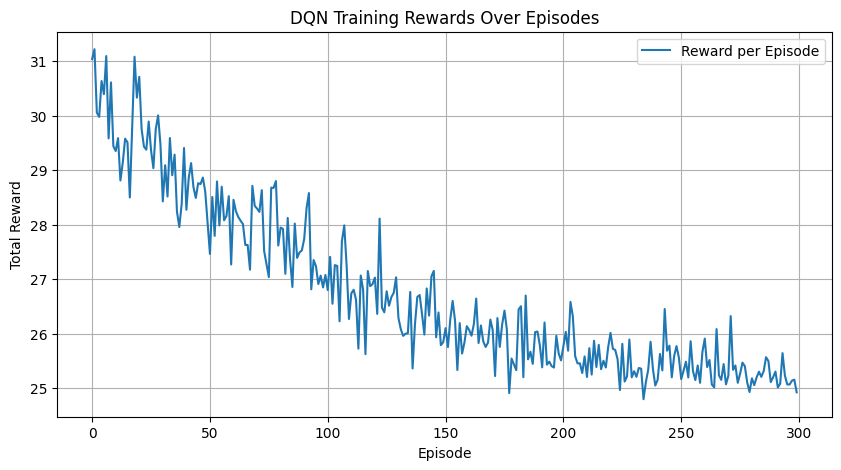

In [ ]:
class PortfolioEvaluator:
    @staticmethod
    def calculate_metrics(stock_data):
        metrics = {
            'return': np.mean(stock_data[:, 0]) if stock_data.size > 0 else 0,
            'risk': np.std(stock_data[:, 0]) if stock_data.size > 0 else 0,
            'profitability': np.mean(stock_data[:, 2]) if stock_data.size > 0 else 0,
            'liquidity': np.mean(stock_data[:, 3]) if stock_data.size > 0 else 0,
            'growth': np.mean(stock_data[:, 4]) if stock_data.size > 0 else 0,
            'risk_score': np.mean(stock_data[:, 5]) if stock_data.size > 0 else 0,
            'valuation': np.mean(stock_data[:, 1]) if stock_data.size > 0 else 0
        }

        risk_free_rate = 0.05
        metrics['sharpe_ratio'] = (metrics['return'] - risk_free_rate) / metrics['risk'] if metrics['risk'] != 0 else 0

        return metrics

class StockDataPreprocessor:
    @staticmethod
    def preprocess_stock_data(file_path):

        try:
            df_stock = pd.read_csv(file_path, usecols=[
                "Stock Name", "return", "valuation", "profitability",
                "liquidity", "growth", "risk",
                "Final Weighted Score", "Final Normalized Score"
            ])
        except Exception as e:
            print(f"Error reading CSV file: {e}")
            return None, None

        nifty_50_stocks = [
            "Adani Enterprises Ltd.", "Adani Ports & Special Economic Zone Ltd.", "Apollo Hospitals Enterprise Ltd.",
            "Asian Paints Ltd.", "Axis Bank Ltd.", "Bajaj Auto Ltd.", "Bajaj Finance Ltd.", "Bajaj Finserv Ltd.",
            "Bharti Airtel Ltd.", "Britannia Industries Ltd.", "Cipla Ltd.", "Coal India Ltd.", "Dr. Reddy'S Laboratories Ltd.",
            "Eicher Motors Ltd.", "Grasim Industries Ltd.", "H C L Technologies Ltd.", "H D F C Bank Ltd.",
            "Hindustan Unilever Ltd.", "I T C Ltd.", "Infosys Ltd.", "J S W Steel Ltd.", "Kotak Mahindra Bank Ltd.",
            "Larsen & Toubro Ltd.", "Ltimindtree Ltd.", "Mahindra & Mahindra Ltd.", "Maruti Suzuki India Ltd.",
            "Nestle India Ltd.", "N T P C Ltd.", "Oil & Natural Gas Corpn. Ltd.", "Power Grid Corpn. Of India Ltd.",
            "Reliance Industries Ltd.", "S B I Life Insurance Co. Ltd.", "State Bank Of India",
            "Sun Pharmaceutical Inds. Ltd.", "Tata Consultancy Services Ltd.", "Tata Consumer Products Ltd.",
            "Tata Steel Ltd.", "Tech Mahindra Ltd.", "Titan Company Ltd.", "Ultratech Cement Ltd.", "U P L Ltd.",
            "Wipro Ltd.", "Bharat Electronics Ltd.", "Bharat Petroleum Corpn. Ltd.", "H D F C Life Insurance Co. Ltd.",
            "Hero Motocorp Ltd.", "Hindalco Industries Ltd.", "I C I C I Bank Ltd.", "Indusind Bank Ltd."
        ]

        df_nifty50 = df_stock[df_stock["Stock Name"].isin(nifty_50_stocks)]

        df_stock_sorted = df_stock.sort_values("Final Normalized Score", ascending=False)

        df_top50 = df_stock_sorted.head(50)

        return df_top50, df_nifty50

class StockSelectionEnv(gym.Env):
    def __init__(self, stock_data, nifty50_data, top50_df):
        super(StockSelectionEnv, self).__init__()

        self.stock_data = stock_data
        self.nifty50_data = nifty50_data
        self.top50_df = top50_df
        self.n_stocks = stock_data.shape[0]

        self.action_space = gym.spaces.MultiBinary(self.n_stocks)

        self.observation_space = gym.spaces.Box(
            low=0, high=1, shape=(self.n_stocks,), dtype=np.float32
        )

        self.reset()

    def step(self, action):
        action_int = action.astype(int)

        if np.sum(action_int) > 50:
            weights = self.top50_df["Final Normalized Score"].values
            sorted_indices = np.argsort(weights)[::-1]
            action_int = np.zeros_like(action_int)
            action_int[sorted_indices[:50]] = 1

        elif np.sum(action_int) < 50:
            selected_mask = action_int == 1
            unselected_mask = action_int == 0

            unselected_weights = self.top50_df[unselected_mask]["Final Normalized Score"].values
            unselected_sorted_indices = np.argsort(unselected_weights)[::-1]

            additional_stocks_needed = 50 - np.sum(action_int)
            additional_stocks_needed = min(additional_stocks_needed, len(unselected_sorted_indices))

            for idx in unselected_sorted_indices[:additional_stocks_needed]:
                action_int[idx] = 1

        self.selected_stocks = action_int.astype(np.float32)

        selected_stock_data = self.stock_data[np.where(self.selected_stocks == 1)[0]]

        portfolio_metrics = PortfolioEvaluator.calculate_metrics(selected_stock_data)
        nifty50_metrics = PortfolioEvaluator.calculate_metrics(self.nifty50_data)

        reward_components = {
            'return_diff': portfolio_metrics['return'] - nifty50_metrics['return'],
            'sharpe_ratio_diff': portfolio_metrics['sharpe_ratio'] - nifty50_metrics['sharpe_ratio'],
            'profitability_diff': portfolio_metrics['profitability'] - nifty50_metrics['profitability'],
            'risk_diff': -abs(portfolio_metrics['risk'] - nifty50_metrics['risk']),  # Lower risk is better
            'growth_diff': portfolio_metrics['growth'] - nifty50_metrics['growth']
        }

        weights = {
            'return_diff': 0.3,
            'sharpe_ratio_diff': 0.2,
            'profitability_diff': 0.15,
            'risk_diff': 0.2,
            'growth_diff': 0.15
        }

        reward = sum(reward_components[key] * weights[key] for key in reward_components)

        self.portfolio_metrics = portfolio_metrics
        self.nifty50_metrics = nifty50_metrics

        return self.selected_stocks, reward, False, {
            'portfolio_metrics': portfolio_metrics,
            'nifty50_metrics': nifty50_metrics,
            'reward_components': reward_components
        }

    def reset(self):
        self.current_step = 0
        self.selected_stocks = np.zeros(self.n_stocks, dtype=np.float32)
        num_initial_stocks = min(10, self.n_stocks)
        initial_indices = np.random.choice(self.n_stocks, num_initial_stocks, replace=False)
        self.selected_stocks[initial_indices] = 1
        return self.selected_stocks

class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.network(x)

def train_dqn(env, epochs=300, steps_per_epoch=100):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    model = DQN(env.n_stocks, env.n_stocks).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.MSELoss()

    memory = deque(maxlen=2000)

    gamma = 0.99
    epsilon = 1.0
    epsilon_decay = 0.99
    min_epsilon = 0.01
    batch_size = 64

    rewards_history = []
    portfolio_metrics_history = []
    nifty50_metrics_history = []

    for episode in range(epochs):
        state = env.reset()
        total_reward = 0

        for _ in range(steps_per_epoch):
            state_tensor = torch.tensor(state, dtype=torch.float32, device=device)
            with torch.no_grad():
                action_probs = model(state_tensor)

            if np.random.rand() < epsilon:
                action = (np.random.rand(env.n_stocks) < 0.5).astype(int)
            else:
                action = (action_probs.cpu().numpy() > 0.5).astype(int)

            next_state, reward, done, info = env.step(action)

            memory.append((state, action, reward, next_state))

            portfolio_metrics_history.append(info['portfolio_metrics'])
            nifty50_metrics_history.append(info['nifty50_metrics'])

            if len(memory) > batch_size:
                batch = random.sample(memory, batch_size)
                states, actions, rewards, next_states = zip(*batch)
                states_tensor = torch.tensor(states, dtype=torch.float32, device=device)
                rewards_tensor = torch.tensor(rewards, dtype=torch.float32, device=device)
                next_states_tensor = torch.tensor(next_states, dtype=torch.float32, device=device)
                q_values = model(states_tensor)
                next_q_values = model(next_states_tensor).detach()
                target_q_values = rewards_tensor + gamma * next_q_values.max(dim=1)[0]
                loss = loss_fn(q_values, target_q_values.unsqueeze(1))
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            total_reward += reward
            state = next_state

        epsilon = max(min_epsilon, epsilon * epsilon_decay)

        rewards_history.append(total_reward)

        if (episode + 1) % 10 == 0:
            print(f"Episode {episode+1}: Total Reward = {total_reward:.4f}, Epsilon = {epsilon:.4f}")

    plt.figure(figsize=(10, 5))
    plt.plot(rewards_history, label="Reward per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("DQN Training Rewards Over Episodes")
    plt.legend()
    plt.grid()
    plt.show()
    return model, rewards_history, portfolio_metrics_history, nifty50_metrics_history

def main():
    top_companies_csv_path = "/content/final_results/sharpe_top_150_companies.csv"
    all_stocks_csv_path = "/content/final_results/all_500_stocks.csv"
    df_top50, _ = StockDataPreprocessor.preprocess_stock_data(top_companies_csv_path)
    _, df_nifty50 = StockDataPreprocessor.preprocess_stock_data(all_stocks_csv_path)

    if df_top50 is None or df_nifty50 is None:
        print("Failed to load stock data. Please check the CSV file paths.")
        return

    df_top50_prices = df_top50.drop(columns=["Stock Name"]).to_numpy(dtype=np.float32)
    df_nifty50_prices = df_nifty50.drop(columns=["Stock Name"]).to_numpy(dtype=np.float32)

    print("Top 50 Companies Data Shape:", df_top50_prices.shape)
    print("Nifty 50 Stocks Data Shape:", df_nifty50_prices.shape)
    env = StockSelectionEnv(df_top50_prices, df_nifty50_prices, df_top50)
    trained_model, rewards, portfolio_metrics, nifty50_metrics = train_dqn(env)

    state = env.reset()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    state_tensor = torch.tensor(state, dtype=torch.float32, device=device)

    with torch.no_grad():
        best_action = trained_model(state_tensor).cpu().numpy()

    selected_stocks = np.where(best_action > 0.5)[0]

if __name__ == "__main__":
    main()

In [ ]:
def save_top50_to_csv(df_top50, output_path="top_50_companies.csv"):
    try:
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        df_top50.to_csv(output_path, index=False)
        print(f"Top 50 companies saved to {output_path}")
    except Exception as e:
        print(f"Error saving CSV file: {e}")

top_companies_csv_path = "/content/final_results/sharpe_top_150_companies.csv"
df_top50, _ = StockDataPreprocessor.preprocess_stock_data(top_companies_csv_path)

if df_top50 is not None:
    save_top50_to_csv(df_top50, "/content/portfolios/sharpe_top_50_companies.csv")


Top 50 companies saved to /content/portfolios/sharpe_top_50_companies.csv


In [ ]:
'''def filter_data_by_date(df, date_col="DATE", min_year=2022, max_year=2022):
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce", dayfirst=True)
    df = df[df[date_col].notna()]
    df = df[(df[date_col].dt.year >= min_year) & (df[date_col].dt.year <= max_year)]
    return df'''

In [ ]:
def filter_data_by_date(df, date_col="DATE", min_year=2023, max_year=2023):
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce", dayfirst=True)
    df = df[df[date_col].notna()]
    df = df[(df[date_col].dt.year >= min_year) & (df[date_col].dt.year <= max_year)]
    return df

In [ ]:
'''def filter_data_by_date(df, date_col="DATE", min_year=2024, max_year=2024):
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce", dayfirst=True)
    df = df[df[date_col].notna()]
    df = df[(df[date_col].dt.year >= min_year) & (df[date_col].dt.year <= max_year)]
    return df'''

In [ ]:
output_folder = "/content/Portfolio_Comparison/"
os.makedirs(output_folder, exist_ok=True)
output_file = output_folder + "all_500_stocks.csv"
all_500_stocks.to_csv(output_file, index=False)
output_file

'/content/Portfolio_Comparison/all_500_stocks.csv'

Stock price data sample:
          DATE 360 One Wam Ltd.  3M India Ltd.  A B B India Ltd.  A C C Ltd.  \
679 2023-01-07           443.81       22294.40           2843.60     2415.95   
680 2023-01-14            445.8       22396.60           2899.95     2367.20   
681 2023-01-21           480.56       22707.75           2933.75     2355.60   

     A I A Engineering Ltd. A P L Apollo Tubes Ltd.  \
679                 2510.30                  1119.6   
680                 2525.05                    1135   
681                 2424.40                  1196.7   

    A U Small Finance Bank Ltd. Aadhar Housing Finance Ltd.  \
679                       625.8                               
680                      619.75                               
681                      616.35                               

     Aarti Industries Ltd.  ... Welspun Living Ltd. Westlife Foodworld Ltd.  \
679                 599.05  ...               72.15                   769.2   
680                 58

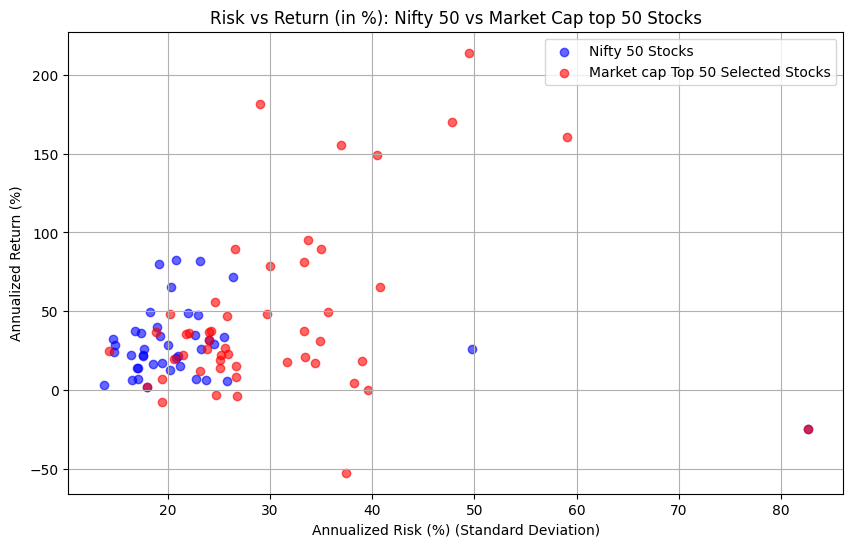

In [ ]:
close_price_file = "/content/data/sample_dates_formated_close.csv"
top_50_stocks_file = "/content/portfolios/market_top_50_companies.csv"


df_prices = pd.read_csv(close_price_file)
df_prices = filter_data_by_date(df_prices, "DATE")
print("Stock price data sample:")
print(df_prices.head(3))
print(df_prices.tail(3))
df_prices.index = pd.to_datetime(df_prices.index, errors='coerce')
df_prices = df_prices[~df_prices.index.isna()]
df_prices = df_prices.apply(pd.to_numeric, errors='coerce')
df_prices.interpolate(method="time", inplace=True)


df_top50 = pd.read_csv(top_50_stocks_file)
top_50_stock_names = df_top50["Stock Name"].tolist()


nifty_50_stocks = [
    "Adani Enterprises Ltd.", "Adani Ports & Special Economic Zone Ltd.", "Apollo Hospitals Enterprise Ltd.",
    "Asian Paints Ltd.", "Axis Bank Ltd.", "Bajaj Auto Ltd.", "Bajaj Finance Ltd.", "Bajaj Finserv Ltd.",
    "Bharti Airtel Ltd.", "Britannia Industries Ltd.", "Cipla Ltd.", "Coal India Ltd.", "Dr. Reddy'S Laboratories Ltd.",
    "Eicher Motors Ltd.", "Grasim Industries Ltd.", "H C L Technologies Ltd.", "H D F C Bank Ltd.",
    "Hindustan Unilever Ltd.", "I T C Ltd.", "Infosys Ltd.", "J S W Steel Ltd.", "Kotak Mahindra Bank Ltd.",
    "Larsen & Toubro Ltd.", "Ltimindtree Ltd.", "Mahindra & Mahindra Ltd.", "Maruti Suzuki India Ltd.",
    "Nestle India Ltd.", "N T P C Ltd.", "Oil & Natural Gas Corpn. Ltd.", "Power Grid Corpn. Of India Ltd.",
    "Reliance Industries Ltd.", "S B I Life Insurance Co. Ltd.", "State Bank Of India",
    "Sun Pharmaceutical Inds. Ltd.", "Tata Consultancy Services Ltd.", "Tata Consumer Products Ltd.",
    "Tata Steel Ltd.", "Tech Mahindra Ltd.", "Titan Company Ltd.", "Ultratech Cement Ltd.", "U P L Ltd.",
    "Wipro Ltd.", "Bharat Electronics Ltd.", "Bharat Petroleum Corpn. Ltd.", "H D F C Life Insurance Co. Ltd.",
    "Hero Motocorp Ltd.", "Hindalco Industries Ltd.", "I C I C I Bank Ltd.", "Indusind Bank Ltd."
]


df_top50_prices = df_prices[df_prices.columns.intersection(top_50_stock_names)]
df_nifty50_prices = df_prices[df_prices.columns.intersection(nifty_50_stocks)]

returns_top50 = df_top50_prices.pct_change(fill_method=None)
returns_nifty50 = df_nifty50_prices.pct_change(fill_method=None)


print("\nPortfolio Shapes:")
print(f"Market Cap top 50 Selected Stocks portfolio shape: {df_top50_prices.shape}")
print(f"Nifty 50 Stocks portfolio shape: {df_nifty50_prices.shape}")


print("\nReturns Shapes:")
print(f"Market Cap top 50 Selected Stocks returns shape: {returns_top50.shape}")
print(f"Nifty 50 Stocks returns shape: {returns_nifty50.shape}")

trading_days_per_year = 252
trading_weeks_per_year = 50
years = len(df_prices) /trading_weeks_per_year
print("years:")
print(years)


def calculate_annualized_metrics(price_df, returns_df):
    annualized_return = ((price_df.iloc[-1] / price_df.iloc[0]) ** (1 / years) - 1) * 100
    annualized_risk = (returns_df.std() * np.sqrt(trading_weeks_per_year)) * 100
    return annualized_return, annualized_risk


annualized_return_top50, annualized_risk_top50 = calculate_annualized_metrics(df_top50_prices, returns_top50)
annualized_return_nifty50, annualized_risk_nifty50 = calculate_annualized_metrics(df_nifty50_prices, returns_nifty50)


scaler = MinMaxScaler()
normalized_return_top50 = scaler.fit_transform(annualized_return_top50.values.reshape(-1, 1))
normalized_risk_top50 = scaler.fit_transform(annualized_risk_top50.values.reshape(-1, 1))

normalized_return_nifty50 = scaler.fit_transform(annualized_return_nifty50.values.reshape(-1, 1))
normalized_risk_nifty50 = scaler.fit_transform(annualized_risk_nifty50.values.reshape(-1, 1))


df_top50_results = pd.DataFrame({
    "Stock": annualized_return_top50.index,
    "Annualized Return (%)": np.round(annualized_return_top50.values, 2),
    "Annualized Risk (%)": np.round(annualized_risk_top50.values, 2),
    "Normalized Return": np.round(normalized_return_top50.flatten(), 2),
    "Normalized Risk": np.round(normalized_risk_top50.flatten(), 2)
})

df_nifty50_results = pd.DataFrame({
    "Stock": annualized_return_nifty50.index,
    "Annualized Return (%)": np.round(annualized_return_nifty50.values, 2),
    "Annualized Risk (%)": np.round(annualized_risk_nifty50.values, 2),
    "Normalized Return": np.round(normalized_return_nifty50.flatten(), 2),
    "Normalized Risk": np.round(normalized_risk_nifty50.flatten(), 2)
})


df_top50_results.to_csv("/content/Portfolio_Comparison/market_top_50_annualized_metrics.csv", index=False)
df_nifty50_results.to_csv("/content/Portfolio_Comparison/nifty50_annualized_metrics.csv", index=False)

print("Comparison data saved!")


plt.figure(figsize=(10, 6))


plt.scatter(df_nifty50_results["Annualized Risk (%)"], df_nifty50_results["Annualized Return (%)"],
            color='blue', alpha=0.6, label="Nifty 50 Stocks")


plt.scatter(df_top50_results["Annualized Risk (%)"], df_top50_results["Annualized Return (%)"],
            color='red', alpha=0.6, label="Market cap Top 50 Selected Stocks")

plt.xlabel("Annualized Risk (%) (Standard Deviation)")
plt.ylabel("Annualized Return (%)")
plt.title("Risk vs Return (in %): Nifty 50 vs Market Cap top 50 Stocks")
plt.legend()
plt.grid(True)


plt.savefig("/content/risk_vs_return_comparison.png", dpi=300)
plt.show()


In [ ]:
avg_return_top50 = annualized_return_top50.mean()
avg_risk_top50 = annualized_risk_top50.mean()

avg_return_nifty50 = annualized_return_nifty50.mean()
avg_risk_nifty50 = annualized_risk_nifty50.mean()


ratio_top50 = avg_return_top50 / avg_risk_top50
ratio_nifty50 = avg_return_nifty50 / avg_risk_nifty50


print("\n📊 Portfolio Comparison (Average Values)")
print(f"Market cap top 50 Selected Stocks: Return = {avg_return_top50:.2f}%, Risk = {avg_risk_top50:.2f}%, Return-to-Risk Ratio = {ratio_top50:.2f}")
print(f"NIFTY 50 Stocks: Return = {avg_return_nifty50:.2f}%, Risk = {avg_risk_nifty50:.2f}%, Return-to-Risk Ratio = {ratio_nifty50:.2f}")


if ratio_top50 > ratio_nifty50:
    print("\n🏆 The Market cap top 50 Selected Stocks Portfolio is BETTER! (Higher return-to-risk ratio)")
else:
    print("\n🏆 The NIFTY 50 Portfolio is BETTER! (Higher return-to-risk ratio)")


📊 Portfolio Comparison (Average Values)
Market cap top 50 Selected Stocks: Return = 49.65%, Risk = 30.70%, Return-to-Risk Ratio = 1.62
NIFTY 50 Stocks: Return = 28.66%, Risk = 22.00%, Return-to-Risk Ratio = 1.30

🏆 The Market cap top 50 Selected Stocks Portfolio is BETTER! (Higher return-to-risk ratio)


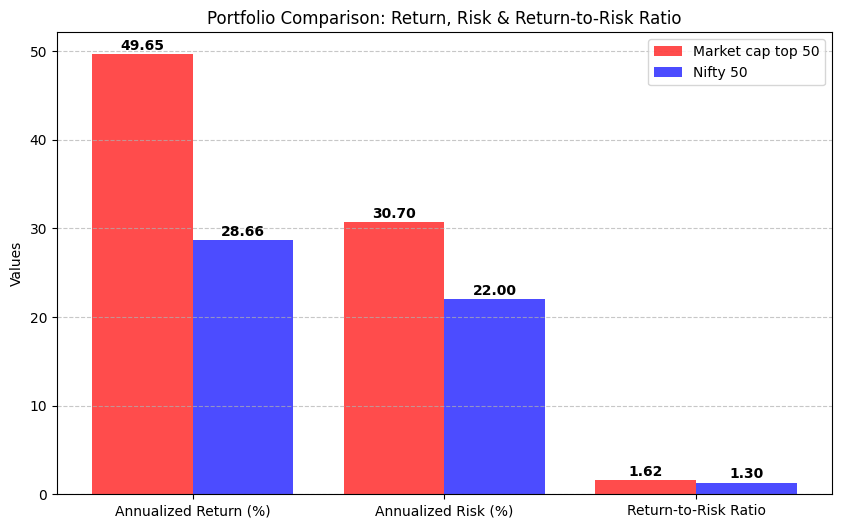

In [ ]:
labels = ["Annualized Return (%)", "Annualized Risk (%)", "Return-to-Risk Ratio"]
top50_values = [avg_return_top50, avg_risk_top50, ratio_top50]
nifty50_values = [avg_return_nifty50, avg_risk_nifty50, ratio_nifty50]

x = np.arange(len(labels))

plt.figure(figsize=(10, 6))
plt.bar(x - 0.2, top50_values, width=0.4, label="Market cap top 50", color='red', alpha=0.7)
plt.bar(x + 0.2, nifty50_values, width=0.4, label="Nifty 50", color='blue', alpha=0.7)

plt.xticks(x, labels)
plt.ylabel("Values")
plt.title("Portfolio Comparison: Return, Risk & Return-to-Risk Ratio")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, v in enumerate(top50_values):
    plt.text(i - 0.2, v + 0.5, f"{v:.2f}", ha='center', fontsize=10, fontweight='bold', color='black')

for i, v in enumerate(nifty50_values):
    plt.text(i + 0.2, v + 0.5, f"{v:.2f}", ha='center', fontsize=10, fontweight='bold', color='black')

plt.show()


Stock price data sample:
          DATE 360 One Wam Ltd.  3M India Ltd.  A B B India Ltd.  A C C Ltd.  \
679 2023-01-07           443.81       22294.40           2843.60     2415.95   
680 2023-01-14            445.8       22396.60           2899.95     2367.20   
681 2023-01-21           480.56       22707.75           2933.75     2355.60   

     A I A Engineering Ltd. A P L Apollo Tubes Ltd.  \
679                 2510.30                  1119.6   
680                 2525.05                    1135   
681                 2424.40                  1196.7   

    A U Small Finance Bank Ltd. Aadhar Housing Finance Ltd.  \
679                       625.8                               
680                      619.75                               
681                      616.35                               

     Aarti Industries Ltd.  ... Welspun Living Ltd. Westlife Foodworld Ltd.  \
679                 599.05  ...               72.15                   769.2   
680                 58

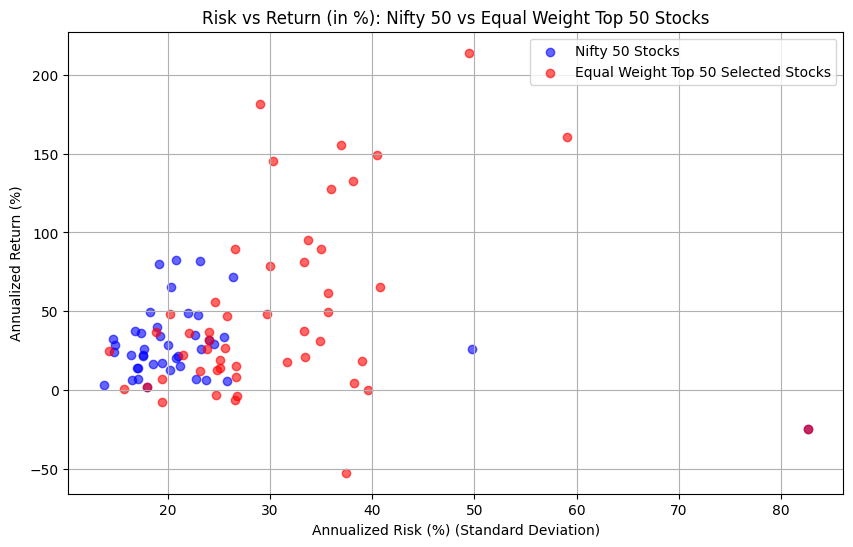

In [ ]:
close_price_file = "/content/data/sample_dates_formated_close.csv"
top_50_stocks_file = "/content/portfolios/equal_top_50_companies.csv"


df_prices = pd.read_csv(close_price_file)
df_prices = filter_data_by_date(df_prices, "DATE")
print("Stock price data sample:")
print(df_prices.head(3))
print(df_prices.tail(3))
df_prices.index = pd.to_datetime(df_prices.index, errors='coerce')
df_prices = df_prices[~df_prices.index.isna()]
df_prices = df_prices.apply(pd.to_numeric, errors='coerce')
df_prices.interpolate(method="time", inplace=True)


df_top50 = pd.read_csv(top_50_stocks_file)
top_50_stock_names = df_top50["Stock Name"].tolist()


nifty_50_stocks = [
    "Adani Enterprises Ltd.", "Adani Ports & Special Economic Zone Ltd.", "Apollo Hospitals Enterprise Ltd.",
    "Asian Paints Ltd.", "Axis Bank Ltd.", "Bajaj Auto Ltd.", "Bajaj Finance Ltd.", "Bajaj Finserv Ltd.",
    "Bharti Airtel Ltd.", "Britannia Industries Ltd.", "Cipla Ltd.", "Coal India Ltd.", "Dr. Reddy'S Laboratories Ltd.",
    "Eicher Motors Ltd.", "Grasim Industries Ltd.", "H C L Technologies Ltd.", "H D F C Bank Ltd.",
    "Hindustan Unilever Ltd.", "I T C Ltd.", "Infosys Ltd.", "J S W Steel Ltd.", "Kotak Mahindra Bank Ltd.",
    "Larsen & Toubro Ltd.", "Ltimindtree Ltd.", "Mahindra & Mahindra Ltd.", "Maruti Suzuki India Ltd.",
    "Nestle India Ltd.", "N T P C Ltd.", "Oil & Natural Gas Corpn. Ltd.", "Power Grid Corpn. Of India Ltd.",
    "Reliance Industries Ltd.", "S B I Life Insurance Co. Ltd.", "State Bank Of India",
    "Sun Pharmaceutical Inds. Ltd.", "Tata Consultancy Services Ltd.", "Tata Consumer Products Ltd.",
    "Tata Steel Ltd.", "Tech Mahindra Ltd.", "Titan Company Ltd.", "Ultratech Cement Ltd.", "U P L Ltd.",
    "Wipro Ltd.", "Bharat Electronics Ltd.", "Bharat Petroleum Corpn. Ltd.", "H D F C Life Insurance Co. Ltd.",
    "Hero Motocorp Ltd.", "Hindalco Industries Ltd.", "I C I C I Bank Ltd.", "Indusind Bank Ltd."
]


df_top50_prices = df_prices[df_prices.columns.intersection(top_50_stock_names)]
df_nifty50_prices = df_prices[df_prices.columns.intersection(nifty_50_stocks)]

returns_top50 = df_top50_prices.pct_change(fill_method=None)
returns_nifty50 = df_nifty50_prices.pct_change(fill_method=None)


print("\nPortfolio Shapes:")
print(f"Equal Weight top 50 Selected Stocks portfolio shape: {df_top50_prices.shape}")
print(f"Nifty 50 Stocks portfolio shape: {df_nifty50_prices.shape}")


print("\nReturns Shapes:")
print(f"Equal weight top 50 Selected Stocks returns shape: {returns_top50.shape}")
print(f"Nifty 50 Stocks returns shape: {returns_nifty50.shape}")

trading_days_per_year = 252
trading_weeks_per_year = 50
years = len(df_prices) /trading_weeks_per_year
print("years:")
print(years)


def calculate_annualized_metrics(price_df, returns_df):
    annualized_return = ((price_df.iloc[-1] / price_df.iloc[0]) ** (1 / years) - 1) * 100
    annualized_risk = (returns_df.std() * np.sqrt(trading_weeks_per_year)) * 100
    return annualized_return, annualized_risk


annualized_return_top50, annualized_risk_top50 = calculate_annualized_metrics(df_top50_prices, returns_top50)
annualized_return_nifty50, annualized_risk_nifty50 = calculate_annualized_metrics(df_nifty50_prices, returns_nifty50)


scaler = MinMaxScaler()
normalized_return_top50 = scaler.fit_transform(annualized_return_top50.values.reshape(-1, 1))
normalized_risk_top50 = scaler.fit_transform(annualized_risk_top50.values.reshape(-1, 1))

normalized_return_nifty50 = scaler.fit_transform(annualized_return_nifty50.values.reshape(-1, 1))
normalized_risk_nifty50 = scaler.fit_transform(annualized_risk_nifty50.values.reshape(-1, 1))


df_top50_results = pd.DataFrame({
    "Stock": annualized_return_top50.index,
    "Annualized Return (%)": np.round(annualized_return_top50.values, 2),
    "Annualized Risk (%)": np.round(annualized_risk_top50.values, 2),
    "Normalized Return": np.round(normalized_return_top50.flatten(), 2),
    "Normalized Risk": np.round(normalized_risk_top50.flatten(), 2)
})

df_nifty50_results = pd.DataFrame({
    "Stock": annualized_return_nifty50.index,
    "Annualized Return (%)": np.round(annualized_return_nifty50.values, 2),
    "Annualized Risk (%)": np.round(annualized_risk_nifty50.values, 2),
    "Normalized Return": np.round(normalized_return_nifty50.flatten(), 2),
    "Normalized Risk": np.round(normalized_risk_nifty50.flatten(), 2)
})


df_top50_results.to_csv("/content/Portfolio_Comparison/equal_market_top_50_annualized_metrics.csv", index=False)
df_nifty50_results.to_csv("/content/Portfolio_Comparison/nifty50_annualized_metrics.csv", index=False)

print("Comparison data saved!")


plt.figure(figsize=(10, 6))


plt.scatter(df_nifty50_results["Annualized Risk (%)"], df_nifty50_results["Annualized Return (%)"],
            color='blue', alpha=0.6, label="Nifty 50 Stocks")


plt.scatter(df_top50_results["Annualized Risk (%)"], df_top50_results["Annualized Return (%)"],
            color='red', alpha=0.6, label="Equal Weight Top 50 Selected Stocks")

plt.xlabel("Annualized Risk (%) (Standard Deviation)")
plt.ylabel("Annualized Return (%)")
plt.title("Risk vs Return (in %): Nifty 50 vs Equal Weight Top 50 Stocks")
plt.legend()
plt.grid(True)


plt.savefig("/content/risk_vs_return_comparison.png", dpi=300)
plt.show()


In [ ]:
avg_return_top50 = annualized_return_top50.mean()
avg_risk_top50 = annualized_risk_top50.mean()

avg_return_nifty50 = annualized_return_nifty50.mean()
avg_risk_nifty50 = annualized_risk_nifty50.mean()


ratio_top50 = avg_return_top50 / avg_risk_top50
ratio_nifty50 = avg_return_nifty50 / avg_risk_nifty50


print("\n📊 Portfolio Comparison (Average Values)")
print(f"Equal Weight Top 50 Selected Stocks: Return = {avg_return_top50:.2f}%, Risk = {avg_risk_top50:.2f}%, Return-to-Risk Ratio = {ratio_top50:.2f}")
print(f"NIFTY 50 Stocks: Return = {avg_return_nifty50:.2f}%, Risk = {avg_risk_nifty50:.2f}%, Return-to-Risk Ratio = {ratio_nifty50:.2f}")


if ratio_top50 > ratio_nifty50:
    print("\n🏆 The Equal Weight Top 50 Selected Stocks Portfolio is BETTER! (Higher return-to-risk ratio)")
else:
    print("\n🏆 The NIFTY 50 Portfolio is BETTER! (Higher return-to-risk ratio)")


📊 Portfolio Comparison (Average Values)
Equal Weight Top 50 Selected Stocks: Return = 48.77%, Risk = 30.74%, Return-to-Risk Ratio = 1.59
NIFTY 50 Stocks: Return = 28.66%, Risk = 22.00%, Return-to-Risk Ratio = 1.30

🏆 The Equal Weight Top 50 Selected Stocks Portfolio is BETTER! (Higher return-to-risk ratio)


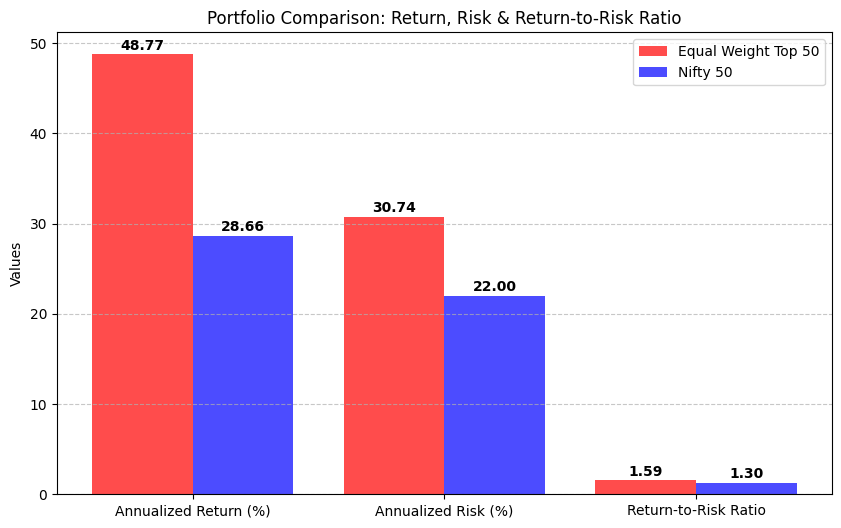

In [ ]:
labels = ["Annualized Return (%)", "Annualized Risk (%)", "Return-to-Risk Ratio"]
top50_values = [avg_return_top50, avg_risk_top50, ratio_top50]
nifty50_values = [avg_return_nifty50, avg_risk_nifty50, ratio_nifty50]

x = np.arange(len(labels))  # X-axis positions

plt.figure(figsize=(10, 6))
plt.bar(x - 0.2, top50_values, width=0.4, label="Equal Weight Top 50", color='red', alpha=0.7)
plt.bar(x + 0.2, nifty50_values, width=0.4, label="Nifty 50", color='blue', alpha=0.7)

plt.xticks(x, labels)
plt.ylabel("Values")
plt.title("Portfolio Comparison: Return, Risk & Return-to-Risk Ratio")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, v in enumerate(top50_values):
    plt.text(i - 0.2, v + 0.5, f"{v:.2f}", ha='center', fontsize=10, fontweight='bold', color='black')

for i, v in enumerate(nifty50_values):
    plt.text(i + 0.2, v + 0.5, f"{v:.2f}", ha='center', fontsize=10, fontweight='bold', color='black')

plt.show()


Stock price data sample:
          DATE 360 One Wam Ltd.  3M India Ltd.  A B B India Ltd.  A C C Ltd.  \
679 2023-01-07           443.81       22294.40           2843.60     2415.95   
680 2023-01-14            445.8       22396.60           2899.95     2367.20   
681 2023-01-21           480.56       22707.75           2933.75     2355.60   

     A I A Engineering Ltd. A P L Apollo Tubes Ltd.  \
679                 2510.30                  1119.6   
680                 2525.05                    1135   
681                 2424.40                  1196.7   

    A U Small Finance Bank Ltd. Aadhar Housing Finance Ltd.  \
679                       625.8                               
680                      619.75                               
681                      616.35                               

     Aarti Industries Ltd.  ... Welspun Living Ltd. Westlife Foodworld Ltd.  \
679                 599.05  ...               72.15                   769.2   
680                 58

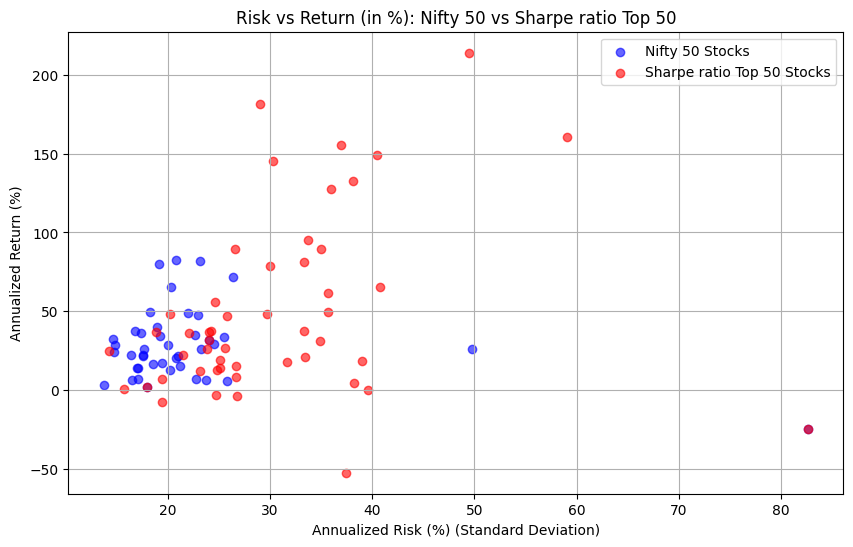

In [ ]:
close_price_file = "/content/data/sample_dates_formated_close.csv"
top_50_stocks_file = "/content/portfolios/sharpe_top_50_companies.csv"


df_prices = pd.read_csv(close_price_file)
df_prices = filter_data_by_date(df_prices, "DATE")
print("Stock price data sample:")
print(df_prices.head(3))
print(df_prices.tail(3))
df_prices.index = pd.to_datetime(df_prices.index, errors='coerce')
df_prices = df_prices[~df_prices.index.isna()]
df_prices = df_prices.apply(pd.to_numeric, errors='coerce')
df_prices.interpolate(method="time", inplace=True)


df_top50 = pd.read_csv(top_50_stocks_file)
top_50_stock_names = df_top50["Stock Name"].tolist()


nifty_50_stocks = [
    "Adani Enterprises Ltd.", "Adani Ports & Special Economic Zone Ltd.", "Apollo Hospitals Enterprise Ltd.",
    "Asian Paints Ltd.", "Axis Bank Ltd.", "Bajaj Auto Ltd.", "Bajaj Finance Ltd.", "Bajaj Finserv Ltd.",
    "Bharti Airtel Ltd.", "Britannia Industries Ltd.", "Cipla Ltd.", "Coal India Ltd.", "Dr. Reddy'S Laboratories Ltd.",
    "Eicher Motors Ltd.", "Grasim Industries Ltd.", "H C L Technologies Ltd.", "H D F C Bank Ltd.",
    "Hindustan Unilever Ltd.", "I T C Ltd.", "Infosys Ltd.", "J S W Steel Ltd.", "Kotak Mahindra Bank Ltd.",
    "Larsen & Toubro Ltd.", "Ltimindtree Ltd.", "Mahindra & Mahindra Ltd.", "Maruti Suzuki India Ltd.",
    "Nestle India Ltd.", "N T P C Ltd.", "Oil & Natural Gas Corpn. Ltd.", "Power Grid Corpn. Of India Ltd.",
    "Reliance Industries Ltd.", "S B I Life Insurance Co. Ltd.", "State Bank Of India",
    "Sun Pharmaceutical Inds. Ltd.", "Tata Consultancy Services Ltd.", "Tata Consumer Products Ltd.",
    "Tata Steel Ltd.", "Tech Mahindra Ltd.", "Titan Company Ltd.", "Ultratech Cement Ltd.", "U P L Ltd.",
    "Wipro Ltd.", "Bharat Electronics Ltd.", "Bharat Petroleum Corpn. Ltd.", "H D F C Life Insurance Co. Ltd.",
    "Hero Motocorp Ltd.", "Hindalco Industries Ltd.", "I C I C I Bank Ltd.", "Indusind Bank Ltd."
]


df_top50_prices = df_prices[df_prices.columns.intersection(top_50_stock_names)]
df_nifty50_prices = df_prices[df_prices.columns.intersection(nifty_50_stocks)]

returns_top50 = df_top50_prices.pct_change(fill_method=None)
returns_nifty50 = df_nifty50_prices.pct_change(fill_method=None)


print("\nPortfolio Shapes:")
print(f"Sharpe ratio Top 50 Selected Stocks portfolio shape: {df_top50_prices.shape}")
print(f"Nifty 50 Stocks portfolio shape: {df_nifty50_prices.shape}")


print("\nReturns Shapes:")
print(f"Sharpe ratio Top 50 Selected Stocks returns shape: {returns_top50.shape}")
print(f"Nifty 50 Stocks returns shape: {returns_nifty50.shape}")

trading_days_per_year = 252
trading_weeks_per_year = 50
years = len(df_prices) /trading_weeks_per_year
print("years:")
print(years)


def calculate_annualized_metrics(price_df, returns_df):
    annualized_return = ((price_df.iloc[-1] / price_df.iloc[0]) ** (1 / years) - 1) * 100
    annualized_risk = (returns_df.std() * np.sqrt(trading_weeks_per_year)) * 100
    return annualized_return, annualized_risk


annualized_return_top50, annualized_risk_top50 = calculate_annualized_metrics(df_top50_prices, returns_top50)
annualized_return_nifty50, annualized_risk_nifty50 = calculate_annualized_metrics(df_nifty50_prices, returns_nifty50)


scaler = MinMaxScaler()
normalized_return_top50 = scaler.fit_transform(annualized_return_top50.values.reshape(-1, 1))
normalized_risk_top50 = scaler.fit_transform(annualized_risk_top50.values.reshape(-1, 1))

normalized_return_nifty50 = scaler.fit_transform(annualized_return_nifty50.values.reshape(-1, 1))
normalized_risk_nifty50 = scaler.fit_transform(annualized_risk_nifty50.values.reshape(-1, 1))


df_top50_results = pd.DataFrame({
    "Stock": annualized_return_top50.index,
    "Annualized Return (%)": np.round(annualized_return_top50.values, 2),
    "Annualized Risk (%)": np.round(annualized_risk_top50.values, 2),
    "Normalized Return": np.round(normalized_return_top50.flatten(), 2),
    "Normalized Risk": np.round(normalized_risk_top50.flatten(), 2)
})

df_nifty50_results = pd.DataFrame({
    "Stock": annualized_return_nifty50.index,
    "Annualized Return (%)": np.round(annualized_return_nifty50.values, 2),
    "Annualized Risk (%)": np.round(annualized_risk_nifty50.values, 2),
    "Normalized Return": np.round(normalized_return_nifty50.flatten(), 2),
    "Normalized Risk": np.round(normalized_risk_nifty50.flatten(), 2)
})


df_top50_results.to_csv("/content/Portfolio_Comparison/sharpe_top_50_annualized_metrics.csv", index=False)
df_nifty50_results.to_csv("/content/Portfolio_Comparison/nifty50_annualized_metrics.csv", index=False)

print("Comparison data saved!")


plt.figure(figsize=(10, 6))


plt.scatter(df_nifty50_results["Annualized Risk (%)"], df_nifty50_results["Annualized Return (%)"],
            color='blue', alpha=0.6, label="Nifty 50 Stocks")


plt.scatter(df_top50_results["Annualized Risk (%)"], df_top50_results["Annualized Return (%)"],
            color='red', alpha=0.6, label="Sharpe ratio Top 50 Stocks")

plt.xlabel("Annualized Risk (%) (Standard Deviation)")
plt.ylabel("Annualized Return (%)")
plt.title("Risk vs Return (in %): Nifty 50 vs Sharpe ratio Top 50")
plt.legend()
plt.grid(True)


plt.savefig("/content/risk_vs_return_comparison.png", dpi=300)
plt.show()


In [ ]:
avg_return_top50 = annualized_return_top50.mean()
avg_risk_top50 = annualized_risk_top50.mean()

avg_return_nifty50 = annualized_return_nifty50.mean()
avg_risk_nifty50 = annualized_risk_nifty50.mean()


ratio_top50 = avg_return_top50 / avg_risk_top50
ratio_nifty50 = avg_return_nifty50 / avg_risk_nifty50


print("\n📊 Portfolio Comparison (Average Values)")
print(f"Top 50 Selected Stocks: Return = {avg_return_top50:.2f}%, Risk = {avg_risk_top50:.2f}%, Return-to-Risk Ratio = {ratio_top50:.2f}")
print(f"NIFTY 50 Stocks: Return = {avg_return_nifty50:.2f}%, Risk = {avg_risk_nifty50:.2f}%, Return-to-Risk Ratio = {ratio_nifty50:.2f}")


if ratio_top50 > ratio_nifty50:
    print("\n🏆 The Sharpe ratio Top 50 Stocks Portfolio is BETTER! (Higher return-to-risk ratio)")
else:
    print("\n🏆 The NIFTY 50 Portfolio is BETTER! (Higher return-to-risk ratio)")


📊 Portfolio Comparison (Average Values)
Top 50 Selected Stocks: Return = 49.65%, Risk = 30.70%, Return-to-Risk Ratio = 1.62
NIFTY 50 Stocks: Return = 28.66%, Risk = 22.00%, Return-to-Risk Ratio = 1.30

🏆 The Sharpe ratio Top 50 Stocks Portfolio is BETTER! (Higher return-to-risk ratio)


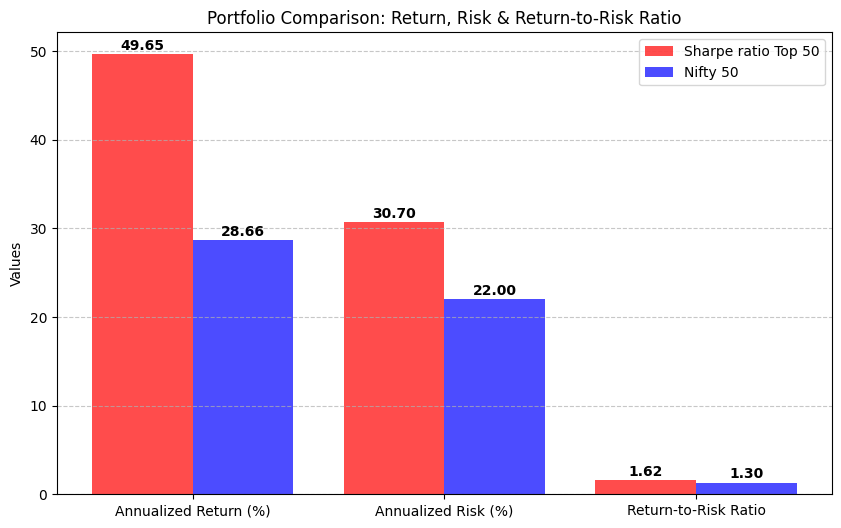

In [ ]:
labels = ["Annualized Return (%)", "Annualized Risk (%)", "Return-to-Risk Ratio"]
top50_values = [avg_return_top50, avg_risk_top50, ratio_top50]
nifty50_values = [avg_return_nifty50, avg_risk_nifty50, ratio_nifty50]

x = np.arange(len(labels))

plt.figure(figsize=(10, 6))
plt.bar(x - 0.2, top50_values, width=0.4, label="Sharpe ratio Top 50", color='red', alpha=0.7)
plt.bar(x + 0.2, nifty50_values, width=0.4, label="Nifty 50", color='blue', alpha=0.7)

plt.xticks(x, labels)
plt.ylabel("Values")
plt.title("Portfolio Comparison: Return, Risk & Return-to-Risk Ratio")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, v in enumerate(top50_values):
    plt.text(i - 0.2, v + 0.5, f"{v:.2f}", ha='center', fontsize=10, fontweight='bold', color='black')

for i, v in enumerate(nifty50_values):
    plt.text(i + 0.2, v + 0.5, f"{v:.2f}", ha='center', fontsize=10, fontweight='bold', color='black')

plt.show()
